In [1]:
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('paper', font_scale=1.2)

hepatitis = fetch_ucirepo(id=46)
X = hepatitis.data.features
y = hepatitis.data.targets

data = X.copy()
data['Class'] = y['Class']
data['Class_binary'] = data['Class'].apply(lambda x: 1 if x == 1 else 0)

# Preprocessing

In [2]:
print("\n=== Duplicates ===")
duplicates = data.duplicated().sum()
print(f"Number of duplicated rows: {duplicates}")


=== Duplicates ===
Number of duplicated rows: 0


In [3]:
print("\n=== Missing Values ===")
missing = data.isnull().sum()
missing_pct = (missing / len(data) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0])

missing_cols = ['Steroid', 'Fatigue', 'Malaise', 'Anorexia', 'Liver Big', 'Liver Firm', 
                'Spleen Palpable', 'Spiders', 'Ascites', 'Varices', 'Bilirubin', 
                'Alk Phosphate', 'Sgot', 'Albumin', 'Protime']
for col in missing_cols:
    for target_class in data['Class_binary'].unique():
        if data[col].dtype == 'object':  # Categorical columns
            mode_value = data.loc[data['Class_binary'] == target_class, col].mode()[0]
            data.loc[(data['Class_binary'] == target_class) & (data[col].isnull()), col] = mode_value
        else:  # Numerical columns
            median_value = data.loc[data['Class_binary'] == target_class, col].median()
            data.loc[(data['Class_binary'] == target_class) & (data[col].isnull()), col] = median_value


=== Missing Values ===
                 Missing Count  Missing %
Steroid                      1       0.65
Fatigue                      1       0.65
Malaise                      1       0.65
Anorexia                     1       0.65
Liver Big                   10       6.45
Liver Firm                  11       7.10
Spleen Palpable              5       3.23
Spiders                      5       3.23
Ascites                      5       3.23
Varices                      5       3.23
Bilirubin                    6       3.87
Alk Phosphate               29      18.71
Sgot                         4       2.58
Albumin                     16      10.32
Protime                     67      43.23


In [4]:
numerical_cols = ['Age', 'Bilirubin', 'Alk Phosphate', 'Sgot', 'Albumin', 'Protime']

for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers
    data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)

In [5]:
print("Distribusi X:\n", X.count())

Distribusi X:
 Age                155
Sex                155
Steroid            154
Antivirals         155
Fatigue            154
Malaise            154
Anorexia           154
Liver Big          145
Liver Firm         144
Spleen Palpable    150
Spiders            150
Ascites            150
Varices            150
Bilirubin          149
Alk Phosphate      126
Sgot               151
Albumin            139
Protime             88
Histology          155
dtype: int64


In [6]:
# Convert all categorical features to dummy variables
categorical_cols = ['Sex', 'Steroid', 'Antivirals', 'Fatigue', 'Malaise', 'Anorexia', 
                    'Liver Big', 'Liver Firm', 'Spleen Palpable', 'Spiders', 'Ascites', 
                    'Varices', 'Histology']
data = pd.get_dummies(data, columns=categorical_cols, prefix=categorical_cols, dtype=int)

In [7]:
X_processed = data.drop(['Class', 'Class_binary'], axis=1)
y_processed = data['Class_binary']

print("Distribusi X:\n", X_processed.count())
print("Distribusi kelas:\n", y_processed.value_counts())

Distribusi X:
 Age                    155
Bilirubin              155
Alk Phosphate          155
Sgot                   155
Albumin                155
Protime                155
Sex_1                  155
Sex_2                  155
Steroid_1.0            155
Steroid_2.0            155
Antivirals_1           155
Antivirals_2           155
Fatigue_1.0            155
Fatigue_2.0            155
Malaise_1.0            155
Malaise_2.0            155
Anorexia_1.0           155
Anorexia_2.0           155
Liver Big_1.0          155
Liver Big_2.0          155
Liver Firm_1.0         155
Liver Firm_2.0         155
Spleen Palpable_1.0    155
Spleen Palpable_2.0    155
Spiders_1.0            155
Spiders_2.0            155
Ascites_1.0            155
Ascites_2.0            155
Varices_1.0            155
Varices_2.0            155
Histology_1            155
Histology_2            155
dtype: int64
Distribusi kelas:
 Class_binary
0    123
1     32
Name: count, dtype: int64


# Modeling

In [8]:
def define_reflex_zones_automated(X, y, corr_threshold=0.15, prop_threshold=0.35, odds_ratio_threshold=1.5, class_weight=1.0):
    reflex_zones = {}
    correlations = X.corrwith(y)
    class_weighted_corr = correlations * (y.mean() * class_weight + (1 - y.mean()) * (1 - class_weight))

    numeric_features = ['Age', 'Bilirubin', 'Alk Phosphate', 'Sgot', 'Albumin', 'Protime']
    for feature in numeric_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            if class_weighted_corr[feature] > 0:
                threshold = X[feature].quantile(0.75)
                reflex_zones[feature] = lambda x, t=threshold: x > t
            else:
                threshold = X[feature].quantile(0.25)
                reflex_zones[feature] = lambda x, t=threshold: x < t

    categorical_features = [col for col in X.columns if col not in numeric_features]
    for feature in categorical_features:
        if abs(class_weighted_corr[feature]) > corr_threshold:
            prop_class_1 = X.loc[y == 1, feature].mean()
            prop_class_0 = X.loc[y == 0, feature].mean()
            odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
            odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
            odds_ratio = odds_1 / (odds_0 + 1e-10)
            if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        corr_threshold = max(0.10, corr_threshold - 0.05)
        prop_threshold = max(0.25, prop_threshold - 0.05)
        odds_ratio_threshold = max(1.0, odds_ratio_threshold - 0.2)
        for feature in numeric_features:
            if abs(correlations[feature]) > corr_threshold:
                if correlations[feature] > 0:
                    threshold = X[feature].quantile(0.75)
                    reflex_zones[feature] = lambda x, t=threshold: x > t
                else:
                    threshold = X[feature].quantile(0.25)
                    reflex_zones[feature] = lambda x, t=threshold: x < t
        for feature in categorical_features:
            if abs(correlations[feature]) > corr_threshold:
                prop_class_1 = X.loc[y == 1, feature].mean()
                prop_class_0 = X.loc[y == 0, feature].mean()
                odds_1 = prop_class_1 / (1 - prop_class_1 + 1e-10)
                odds_0 = prop_class_0 / (1 - prop_class_0 + 1e-10)
                odds_ratio = odds_1 / (odds_0 + 1e-10)
                if prop_class_1 > prop_threshold and odds_ratio > odds_ratio_threshold:
                    reflex_zones[feature] = lambda x: x == 1

    if not reflex_zones:
        raise ValueError("No reflex zones defined even with loosened thresholds. Check data distribution.")
    return reflex_zones

class ReflexLearningAlgorithm(BaseEstimator, ClassifierMixin):
    def __init__(self, reflex_zones=None, threshold_score=3.0, key_zones=None, key_weight=1.0, min_activation=1):
        self.reflex_zones = reflex_zones
        self.threshold_score = threshold_score
        self.key_zones = key_zones if key_zones is not None else []
        self.key_weight = key_weight
        self.min_activation = min_activation
    
    def fit(self, X, y=None):
        if self.reflex_zones is None:
            self.reflex_zones = define_reflex_zones_automated(X, y)
        self.reflex_zones_ = self.reflex_zones
        return self
    
    def predict(self, X):
        predictions = []
        scores = []
        for i in range(X.shape[0]):
            base_score = sum(1 for feature, condition in self.reflex_zones.items() 
                             if condition(X.iloc[i][feature]))
            key_score = sum(1 for feature, condition in self.reflex_zones.items()
                            if feature in self.key_zones and condition(X.iloc[i][feature])) * self.key_weight
            total_score = base_score + key_score
            active_zones = sum(1 for feature, condition in self.reflex_zones.items() 
                               if condition(X.iloc[i][feature]))
            adjusted_threshold = self.threshold_score - (self.key_weight * 0.4 if active_zones >= self.min_activation else 0)
            scores.append(total_score)
            if total_score >= adjusted_threshold:
                predictions.append(1)
            else:
                predictions.append(0)
        self.scores_ = np.array(scores)  # Ensure scores_ is always updated for the current input
        return np.array(predictions)
    
    def get_params(self, deep=True):
        return {'reflex_zones': self.reflex_zones, 'threshold_score': self.threshold_score, 'key_zones': self.key_zones, 'key_weight': self.key_weight, 'min_activation': self.min_activation}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

def evaluate_rla(model, X_train, X_test, y_train, y_test, model_name):
    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time
    y_score_train = model.scores_

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    y_score_test = model.scores_
    
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nReflex Zones Defined (Automated):")
    for feature, condition in model.reflex_zones_.items():
        print(f"{feature}: {condition.__code__.co_code}")

    roc_auc_train = roc_auc_score(y_train, y_score_train)
    roc_auc_test = roc_auc_score(y_test, y_score_test)

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print(f"ROC AUC: {roc_auc_train:.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print(f"ROC AUC: {roc_auc_test:.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores_acc = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')

    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores_acc.round(4)}")
    print(f"Mean Accuracy: {cv_scores_acc.mean():.4f} ± {cv_scores_acc.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_processed, test_size=0.15, random_state=42, stratify=y_processed
)

print("Distribusi kelas (y_train) tanpa SMOTE:\n", y_train.value_counts())

Distribusi kelas (y_train) tanpa SMOTE:
 Class_binary
0    104
1     27
Name: count, dtype: int64



=== RLA Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0492 detik
Waktu Prediksi (Training Set): 0.3090 detik
Waktu Prediksi (Testing Set): 0.0525 detik

Reflex Zones Defined (Automated):
Age: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Bilirubin: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Alk Phosphate: b'\x97\x00|\x00|\x01k\x04\x00\x00\x00\x00S\x00'
Albumin: b'\x97\x00|\x00|\x01k\x00\x00\x00\x00\x00S\x00'
Protime: b'\x97\x00|\x00|\x01k\x00\x00\x00\x00\x00S\x00'
Sex_1: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Steroid_1.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Antivirals_2: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Fatigue_1.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Malaise_1.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Liver Big_2.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Spleen Palpable_1.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Spiders_1.0: b'\x97\x00|\x00d\x01k\x02\x00\x00\x00\x00S\x00'
Ascites_1

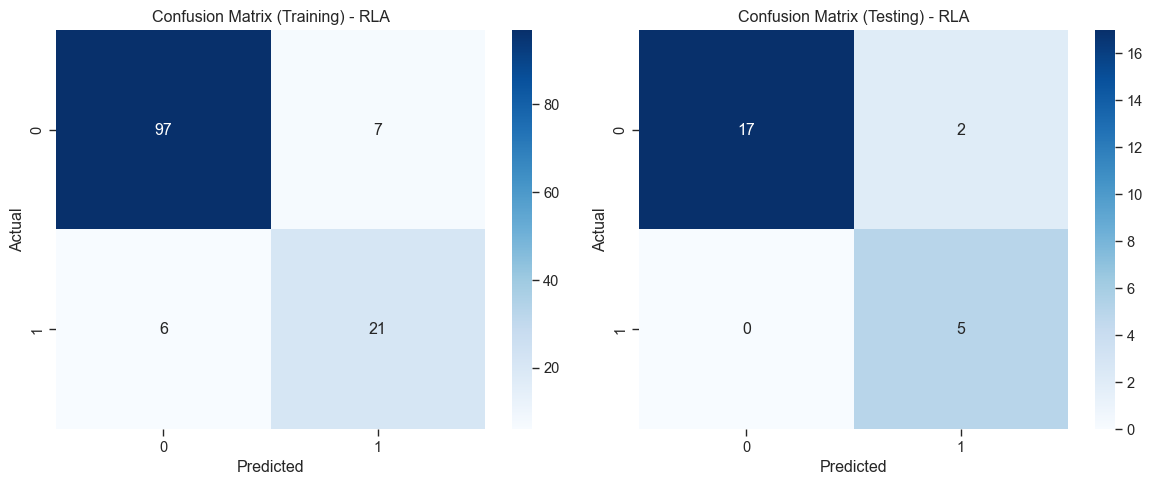

In [20]:
rla = ReflexLearningAlgorithm(threshold_score=10.0)  # key_zones optional
evaluate_rla(rla, X_train, X_test, y_train, y_test, model_name="RLA")

# Pembanding

In [21]:
# --- Helper Function for Evaluation ---
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):

    start_time = time.perf_counter()
    model.fit(X_train, y_train)
    training_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_train = model.predict(X_train)
    train_pred_time = time.perf_counter() - start_time

    start_time = time.perf_counter()
    y_pred_test = model.predict(X_test)
    test_pred_time = time.perf_counter() - start_time
    
    # Cetak waktu komputasi
    print(f"\n=== {model_name} Baseline Model Evaluation ===")
    print(f"\nWaktu Komputasi:")
    print(f"Waktu Pelatihan: {training_time:.4f} detik")
    print(f"Waktu Prediksi (Training Set): {train_pred_time:.4f} detik")
    print(f"Waktu Prediksi (Testing Set): {test_pred_time:.4f} detik")

    print("\nTraining Performance:")
    print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
    print(f"Precision: {precision_score(y_train, y_pred_train):.4f}")
    print(f"Recall: {recall_score(y_train, y_pred_train):.4f}")
    print(f"F1-Score: {f1_score(y_train, y_pred_train):.4f}")
    print("\nClassification Report (Training):")
    print(classification_report(y_train, y_pred_train))

    print("\nTesting Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred_test):.4f}")
    print(f"Recall: {recall_score(y_test, y_pred_test):.4f}")
    print(f"F1-Score: {f1_score(y_test, y_pred_test):.4f}")
    print("\nClassification Report (Testing):")
    print(classification_report(y_test, y_pred_test))

    cv_scores = cross_val_score(model, X_processed, y_processed, cv=5, scoring='accuracy')
    print("\nCross-Validation (5-Fold) Accuracy:")
    print(f"Scores: {cv_scores.round(4)}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Training) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Testing) - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    if hasattr(model, 'predict_proba'):
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_test = model.decision_function(X_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_proba_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_proba_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {auc_train:.4f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'ROC Curve - {model_name}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train)
    precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_test)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_train, precision_train, label='Train Precision-Recall')
    plt.plot(recall_test, precision_test, label='Test Precision-Recall')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_processed, y_processed, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
    )
    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Accuracy')
    plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Accuracy')
    plt.fill_between(train_sizes, train_scores.mean(axis=1) - train_scores.std(axis=1),
                     train_scores.mean(axis=1) + train_scores.std(axis=1), alpha=0.1)
    plt.fill_between(train_sizes, test_scores.mean(axis=1) - test_scores.std(axis=1),
                     test_scores.mean(axis=1) + test_scores.std(axis=1), alpha=0.1)
    plt.title(f'Learning Curve - {model_name}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        print(f"\nFeature Importance ({model_name}):")
        for feature, importance in feature_importance.sort_values(ascending=False).items():
            print(f"{feature}: {importance:.4f}")
        plt.figure(figsize=(10, 6))
        feature_importance.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Importance - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Importance')
        plt.tight_layout()
        plt.show()
    elif hasattr(model, 'coef_'):
        feature_coefficients = pd.Series(model.coef_[0], index=X_train.columns)
        print(f"\nFeature Coefficients ({model_name}):")
        for feature, coef in feature_coefficients.sort_values(ascending=False).items():
            print(f"{feature}: {coef:.4f}")
        plt.figure(figsize=(10, 6))
        feature_coefficients.sort_values(ascending=False).plot(kind='bar')
        plt.title(f'Feature Coefficients - {model_name}')
        plt.xlabel('Features')
        plt.ylabel('Coefficient')
        plt.tight_layout()
        plt.show()

## Decision Tree


=== Decision Tree Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0082 detik
Waktu Prediksi (Training Set): 0.0029 detik
Waktu Prediksi (Testing Set): 0.0030 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.7917
Precision: 0.5000
Recall: 0.8000
F1-Score: 0.6154

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.50      0.80      0.62         5

    accuracy                           0.79        24
   macro avg       0.72

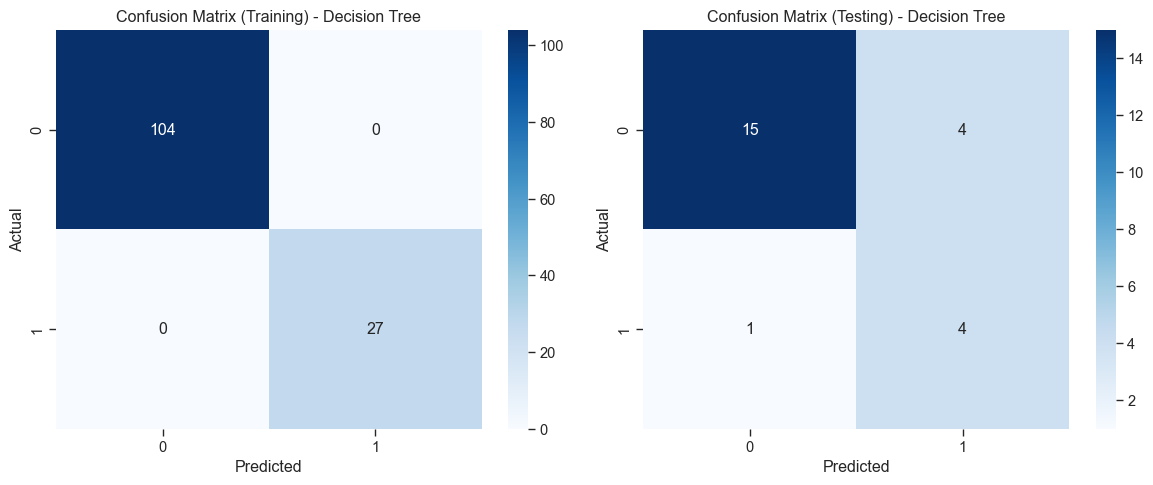

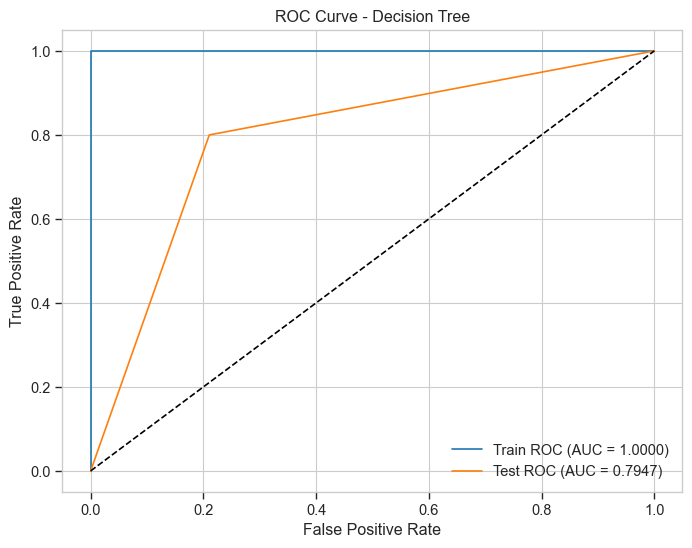

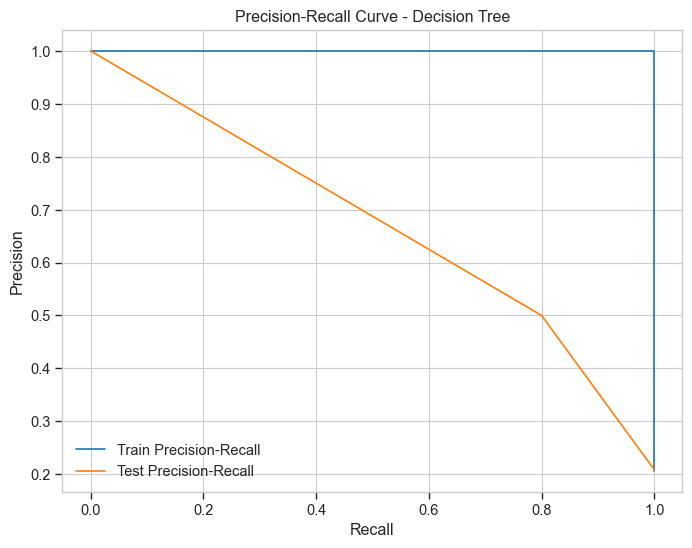

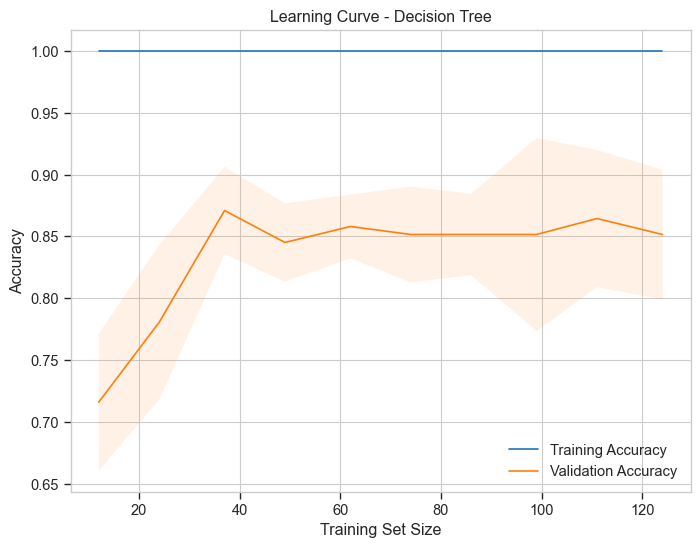


Feature Importance (Decision Tree):
Protime: 0.6543
Ascites_1.0: 0.1103
Bilirubin: 0.1074
Sex_2: 0.0444
Alk Phosphate: 0.0373
Liver Firm_2.0: 0.0373
Varices_2.0: 0.0089
Spiders_1.0: 0.0000
Liver Firm_1.0: 0.0000
Spleen Palpable_1.0: 0.0000
Spleen Palpable_2.0: 0.0000
Age: 0.0000
Spiders_2.0: 0.0000
Liver Big_1.0: 0.0000
Ascites_2.0: 0.0000
Varices_1.0: 0.0000
Histology_1: 0.0000
Liver Big_2.0: 0.0000
Anorexia_1.0: 0.0000
Anorexia_2.0: 0.0000
Malaise_2.0: 0.0000
Malaise_1.0: 0.0000
Fatigue_2.0: 0.0000
Fatigue_1.0: 0.0000
Antivirals_2: 0.0000
Antivirals_1: 0.0000
Steroid_2.0: 0.0000
Steroid_1.0: 0.0000
Sex_1: 0.0000
Albumin: 0.0000
Sgot: 0.0000
Histology_2: 0.0000


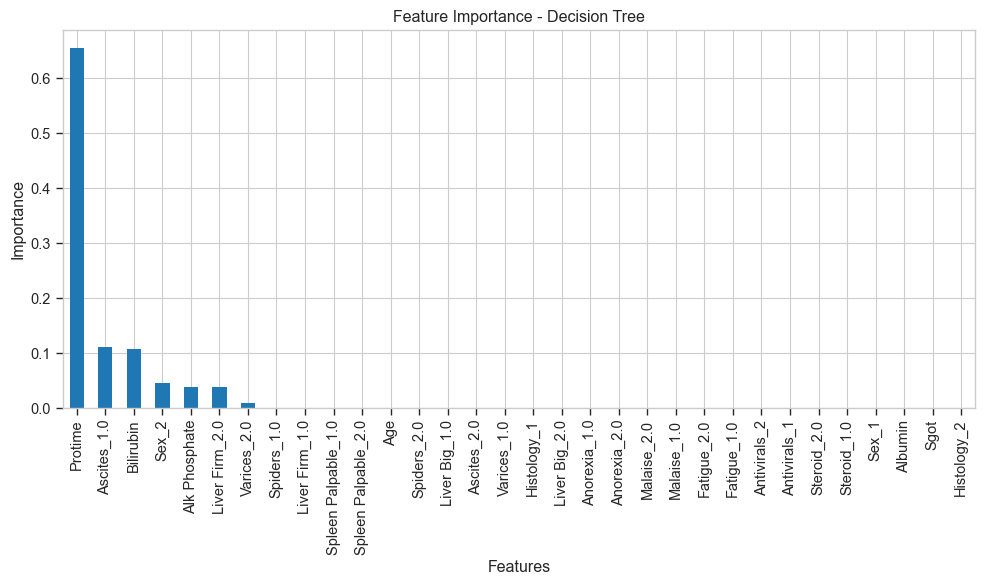

In [22]:
# --- Decision Tree Baseline ---
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train, X_test, y_train, y_test, 'Decision Tree')

## Logistic Regression


=== Logistic Regression Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0759 detik
Waktu Prediksi (Training Set): 0.0021 detik
Waktu Prediksi (Testing Set): 0.0014 detik

Training Performance:
Accuracy: 0.9542
Precision: 0.9200
Recall: 0.8519
F1-Score: 0.8846

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       104
           1       0.92      0.85      0.88        27

    accuracy                           0.95       131
   macro avg       0.94      0.92      0.93       131
weighted avg       0.95      0.95      0.95       131


Testing Performance:
Accuracy: 0.8750
Precision: 0.7500
Recall: 0.6000
F1-Score: 0.6667

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.75      0.60      0.67         5

    accuracy                           0.88        24
   macro avg     

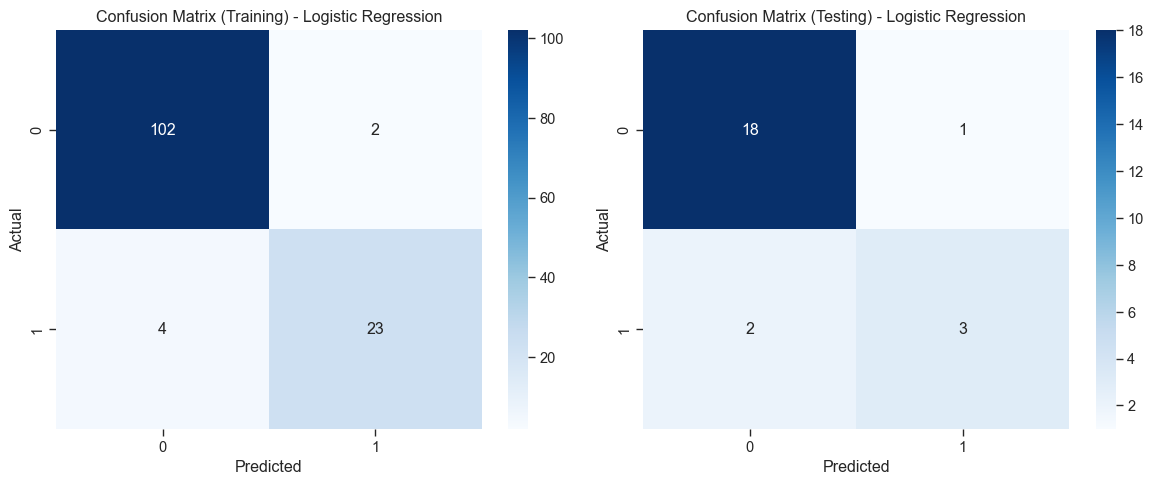

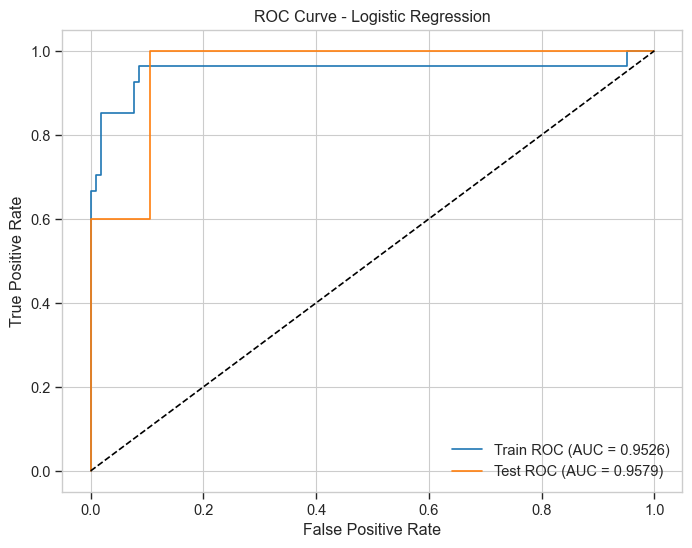

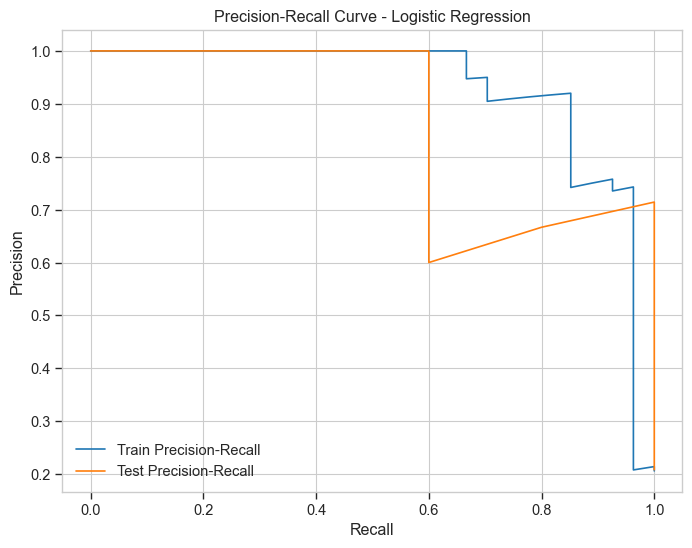

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

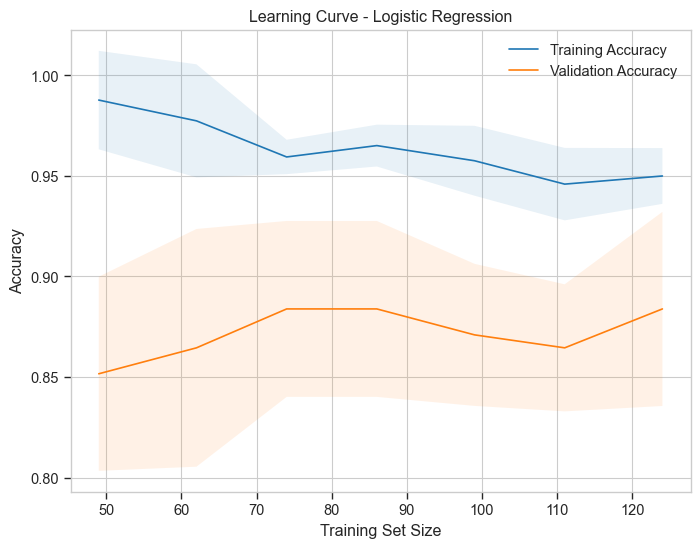


Feature Coefficients (Logistic Regression):
Bilirubin: 1.1871
Spiders_1.0: 0.6217
Sex_1: 0.6021
Ascites_1.0: 0.4139
Anorexia_2.0: 0.4098
Liver Big_2.0: 0.4079
Steroid_1.0: 0.3987
Malaise_1.0: 0.2672
Histology_2: 0.1685
Antivirals_2: 0.1053
Varices_1.0: 0.0973
Liver Firm_2.0: 0.0809
Spleen Palpable_1.0: 0.0752
Fatigue_1.0: 0.0564
Age: 0.0352
Sgot: -0.0061
Alk Phosphate: -0.0096
Fatigue_2.0: -0.0567
Protime: -0.0683
Spleen Palpable_2.0: -0.0755
Liver Firm_1.0: -0.0813
Varices_2.0: -0.0977
Antivirals_1: -0.1056
Histology_1: -0.1688
Malaise_2.0: -0.2675
Steroid_2.0: -0.3991
Liver Big_1.0: -0.4082
Anorexia_1.0: -0.4101
Ascites_2.0: -0.4142
Sex_2: -0.6024
Spiders_2.0: -0.6220
Albumin: -0.7234


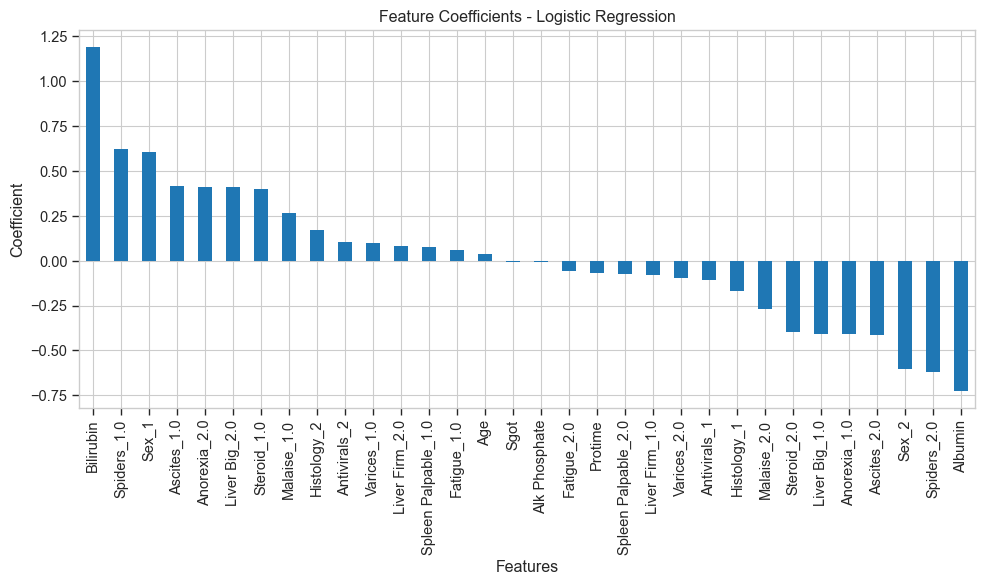

In [24]:
# --- Logistic Regression Baseline ---
lr_model = LogisticRegression(random_state=42, max_iter=1000)
evaluate_model(lr_model, X_train, X_test, y_train, y_test, 'Logistic Regression')

## KNN


=== k-Nearest Neighbors Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0039 detik
Waktu Prediksi (Training Set): 2.4678 detik
Waktu Prediksi (Testing Set): 0.0091 detik

Training Performance:
Accuracy: 0.8931
Precision: 0.8421
Recall: 0.5926
F1-Score: 0.6957

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       104
           1       0.84      0.59      0.70        27

    accuracy                           0.89       131
   macro avg       0.87      0.78      0.82       131
weighted avg       0.89      0.89      0.89       131


Testing Performance:
Accuracy: 0.8333
Precision: 0.6667
Recall: 0.4000
F1-Score: 0.5000

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.67      0.40      0.50         5

    accuracy                           0.83        24
   macro avg     

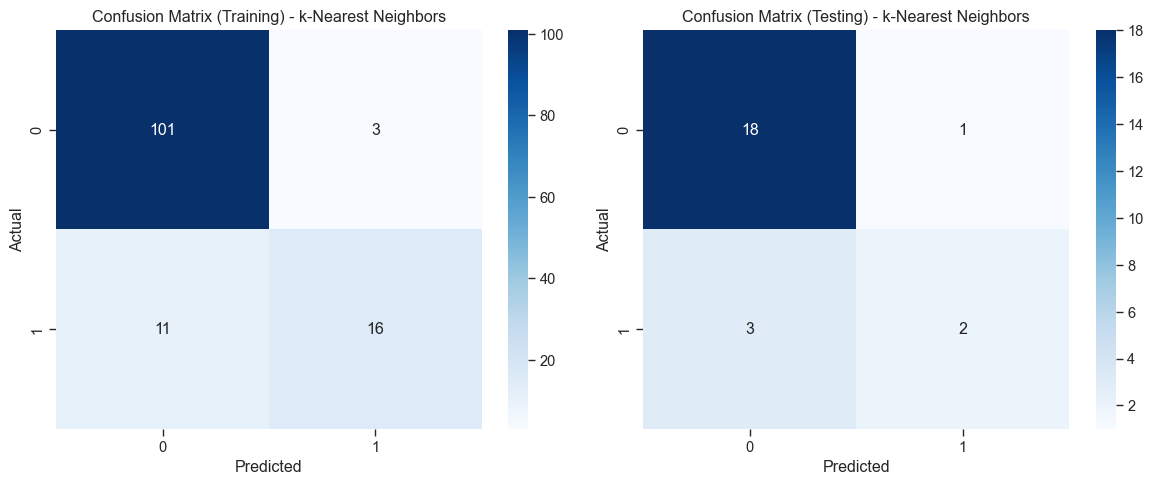

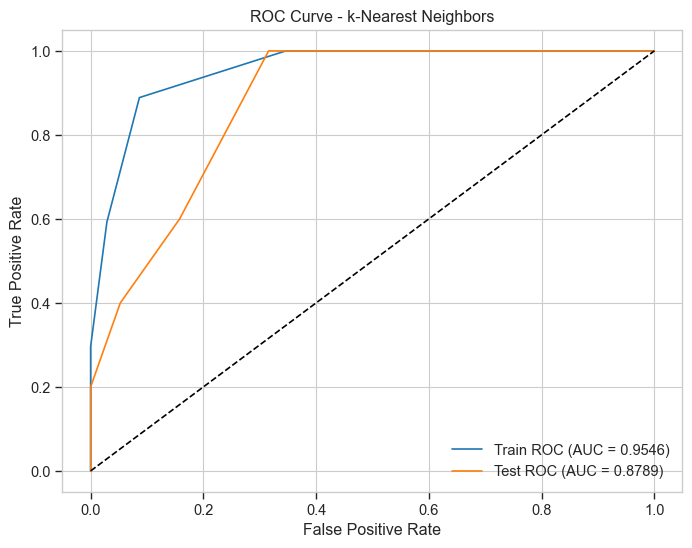

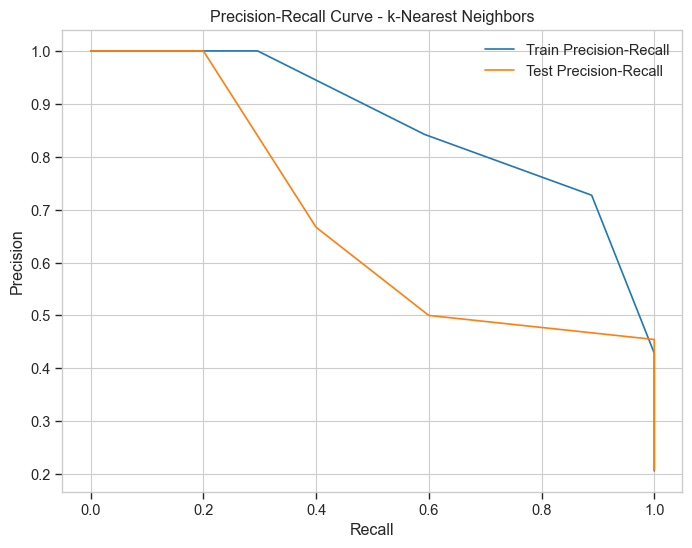

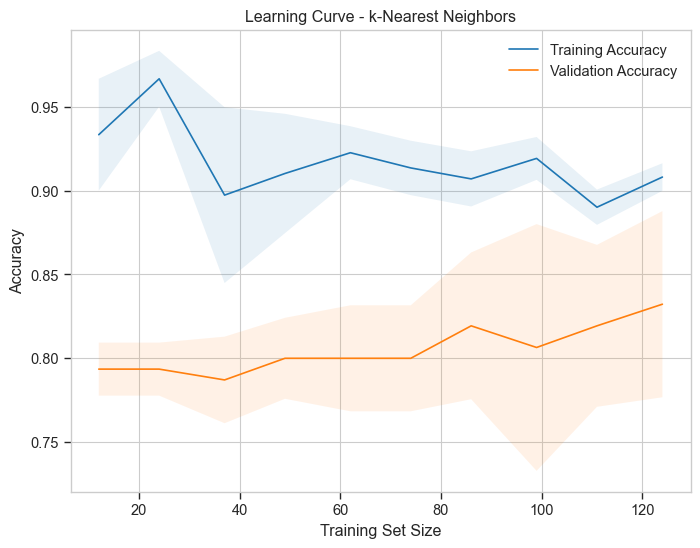

In [25]:
# --- k-Nearest Neighbors Baseline ---
knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, X_test, y_train, y_test, 'k-Nearest Neighbors')

## Naive Bayes


=== Naive Bayes Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0028 detik
Waktu Prediksi (Training Set): 0.0014 detik
Waktu Prediksi (Testing Set): 0.0016 detik

Training Performance:
Accuracy: 0.8092
Precision: 0.5208
Recall: 0.9259
F1-Score: 0.6667

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.98      0.78      0.87       104
           1       0.52      0.93      0.67        27

    accuracy                           0.81       131
   macro avg       0.75      0.85      0.77       131
weighted avg       0.88      0.81      0.83       131


Testing Performance:
Accuracy: 0.6667
Precision: 0.3846
Recall: 1.0000
F1-Score: 0.5556

Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      0.58      0.73        19
           1       0.38      1.00      0.56         5

    accuracy                           0.67        24
   macro avg       0.69  

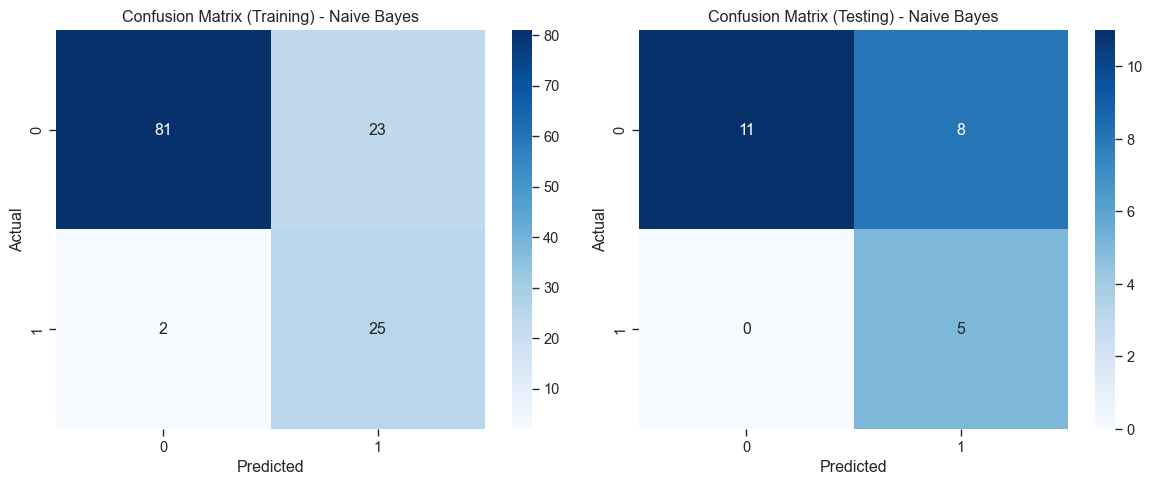

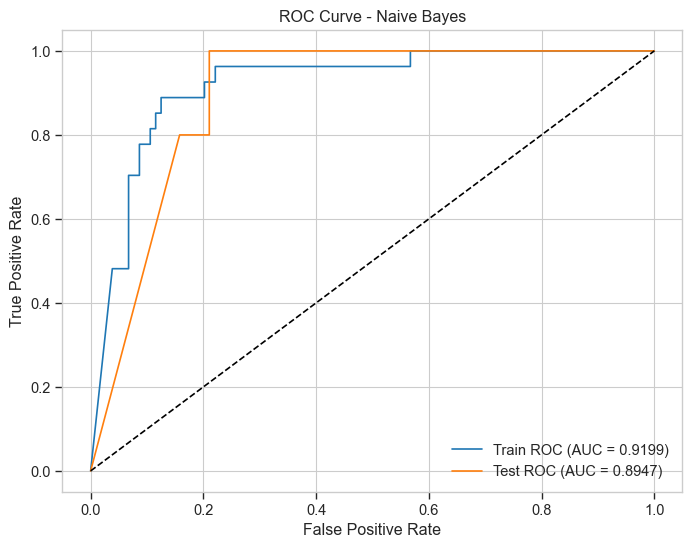

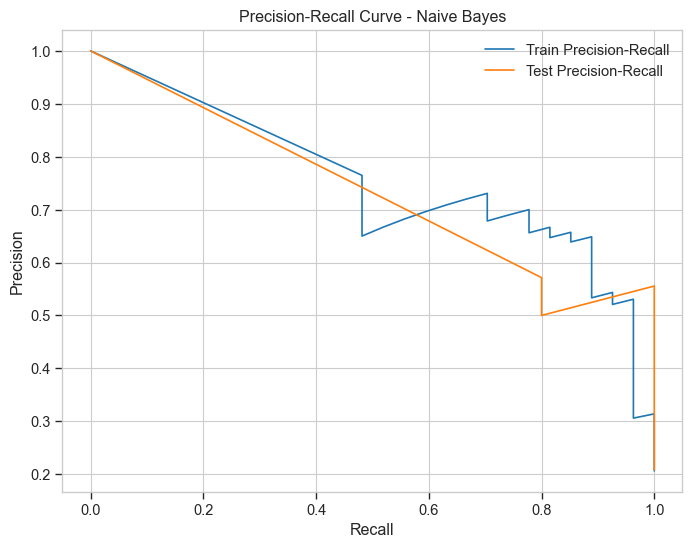

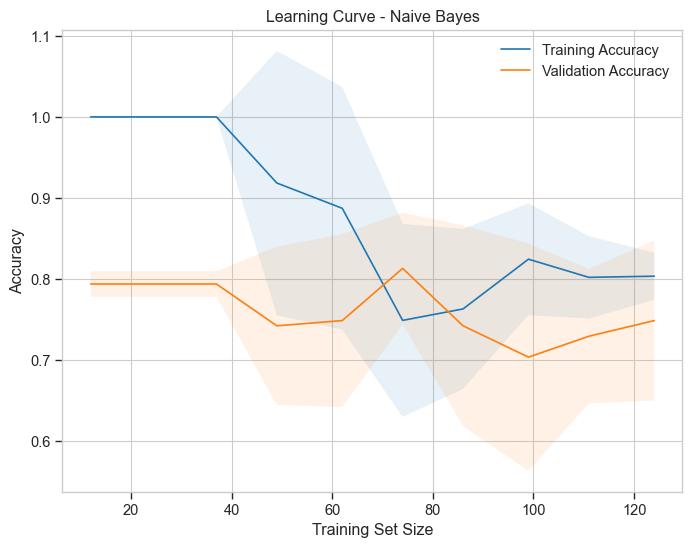

In [26]:
# --- Naive Bayes Baseline ---
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, X_test, y_train, y_test, 'Naive Bayes')

## Support Vector Machine


=== Support Vector Machine Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0094 detik
Waktu Prediksi (Training Set): 0.0034 detik
Waktu Prediksi (Testing Set): 0.0017 detik

Training Performance:
Accuracy: 0.7939
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.79      1.00      0.89       104
           1       0.00      0.00      0.00        27

    accuracy                           0.79       131
   macro avg       0.40      0.50      0.44       131
weighted avg       0.63      0.79      0.70       131


Testing Performance:
Accuracy: 0.7917
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.79      1.00      0.88        19
           1       0.00      0.00      0.00         5

    accuracy                           0.79        24
   macro avg  

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
 

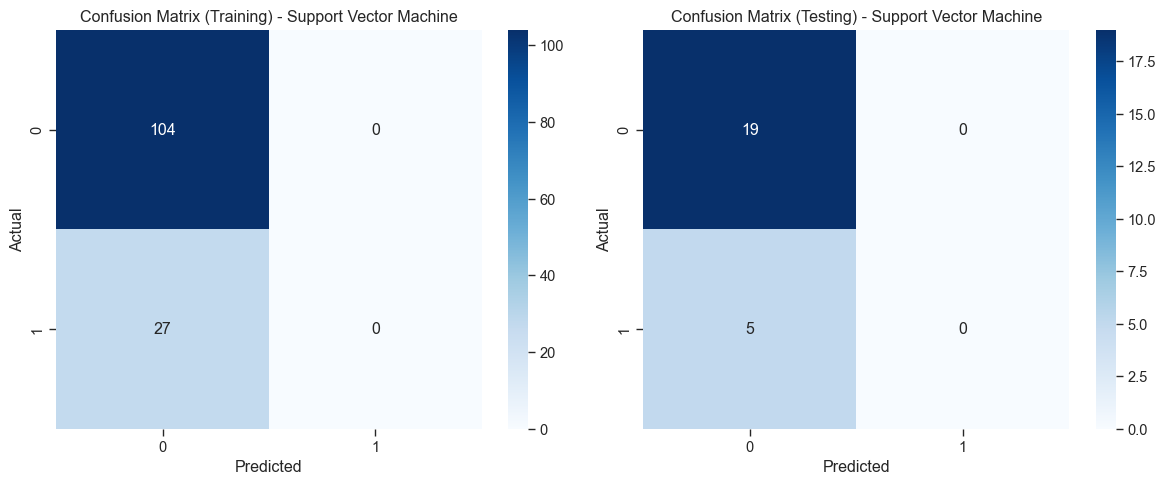

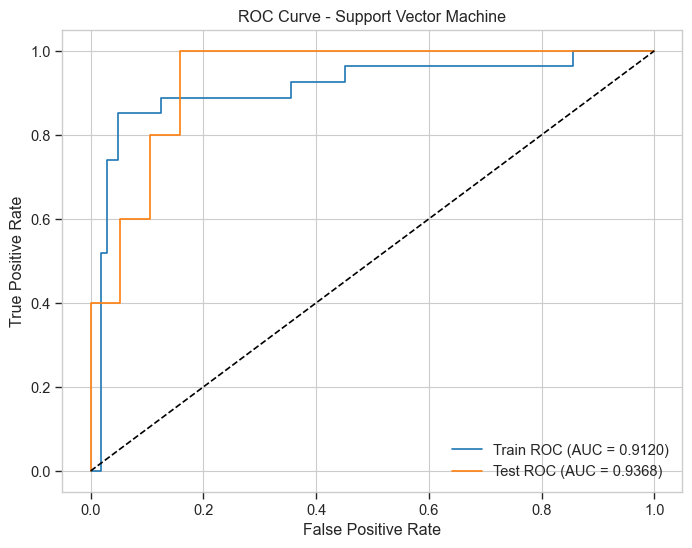

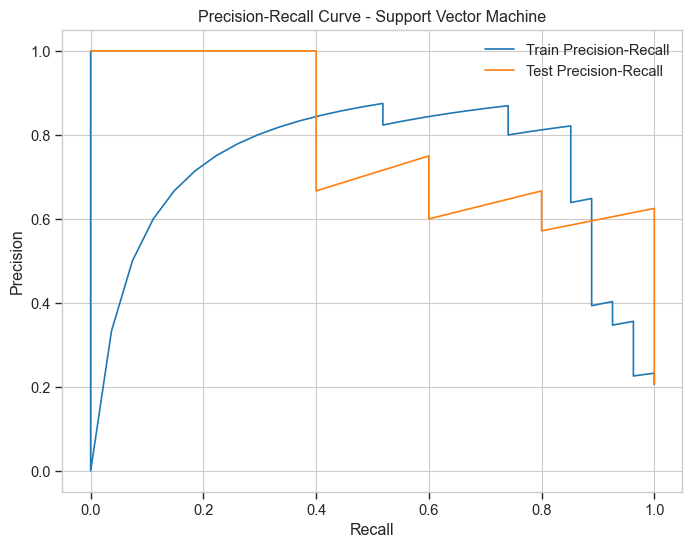

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

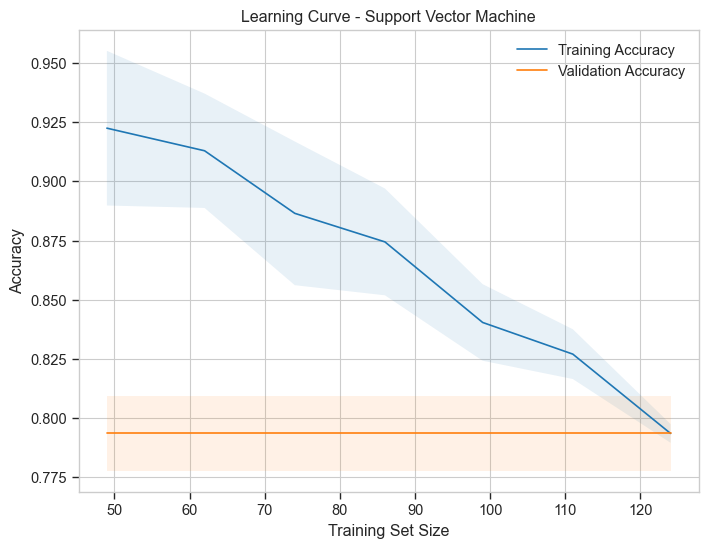

In [27]:
# --- Support Vector Machine Baseline ---
svm_model = SVC(probability=True, random_state=42)
evaluate_model(svm_model, X_train, X_test, y_train, y_test, 'Support Vector Machine')

## Random Forest


=== Random Forest Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1673 detik
Waktu Prediksi (Training Set): 0.0132 detik
Waktu Prediksi (Testing Set): 0.0125 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.9583
Precision: 0.8333
Recall: 1.0000
F1-Score: 0.9091

Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        19
           1       0.83      1.00      0.91         5

    accuracy                           0.96        24
   macro avg       0.92

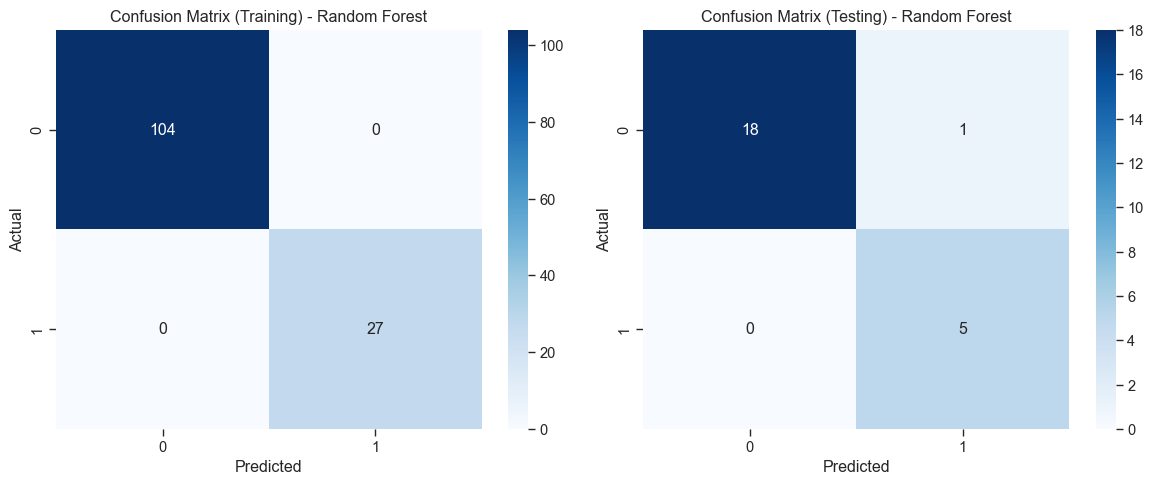

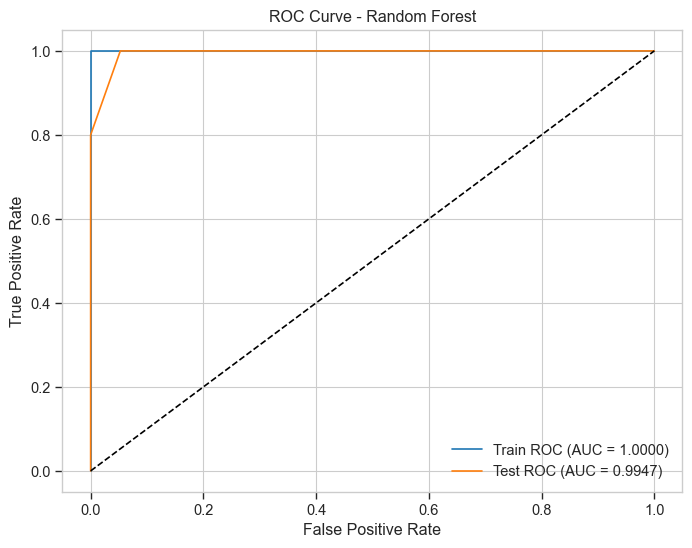

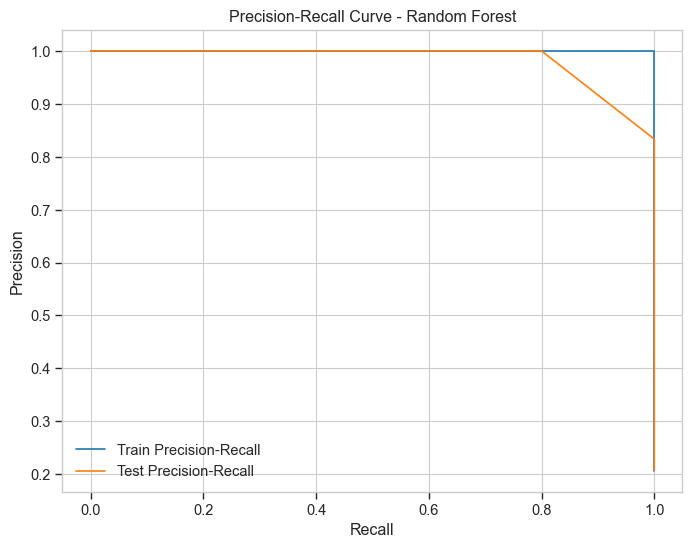

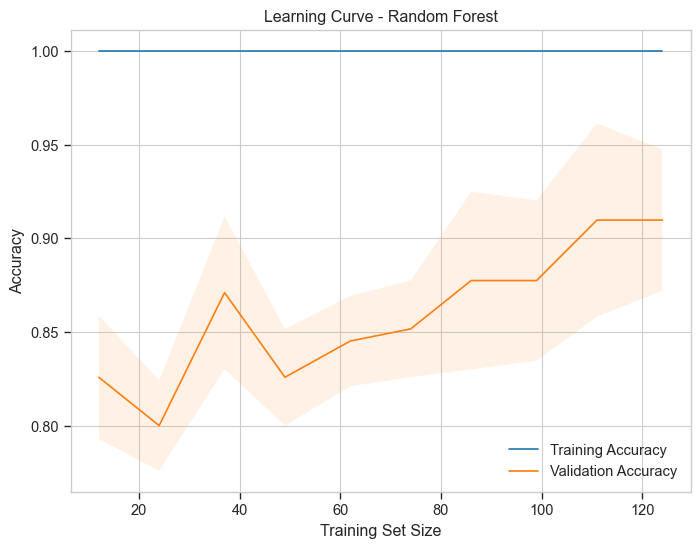


Feature Importance (Random Forest):
Protime: 0.2837
Albumin: 0.1061
Bilirubin: 0.1004
Alk Phosphate: 0.0567
Sgot: 0.0422
Ascites_2.0: 0.0395
Ascites_1.0: 0.0374
Spiders_1.0: 0.0339
Age: 0.0331
Varices_1.0: 0.0308
Spiders_2.0: 0.0258
Histology_1: 0.0222
Malaise_2.0: 0.0219
Liver Firm_1.0: 0.0185
Histology_2: 0.0150
Malaise_1.0: 0.0140
Liver Firm_2.0: 0.0114
Liver Big_2.0: 0.0104
Fatigue_1.0: 0.0103
Varices_2.0: 0.0096
Steroid_1.0: 0.0090
Anorexia_1.0: 0.0086
Sex_1: 0.0081
Spleen Palpable_2.0: 0.0075
Spleen Palpable_1.0: 0.0073
Fatigue_2.0: 0.0071
Sex_2: 0.0067
Steroid_2.0: 0.0062
Liver Big_1.0: 0.0057
Anorexia_2.0: 0.0056
Antivirals_2: 0.0030
Antivirals_1: 0.0024


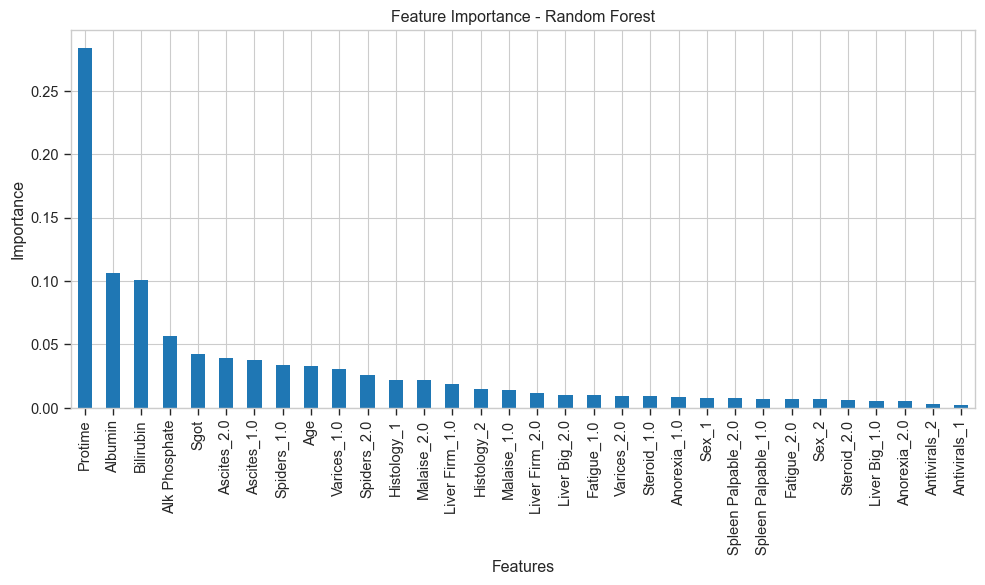

In [28]:
# --- Random Forest Baseline ---
rf_model = RandomForestClassifier(random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')

## Gradient Boosting


=== Gradient Boosting Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1567 detik
Waktu Prediksi (Training Set): 0.0022 detik
Waktu Prediksi (Testing Set): 0.0016 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.7917
Precision: 0.5000
Recall: 0.6000
F1-Score: 0.5455

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        19
           1       0.50      0.60      0.55         5

    accuracy                           0.79        24
   macro avg       

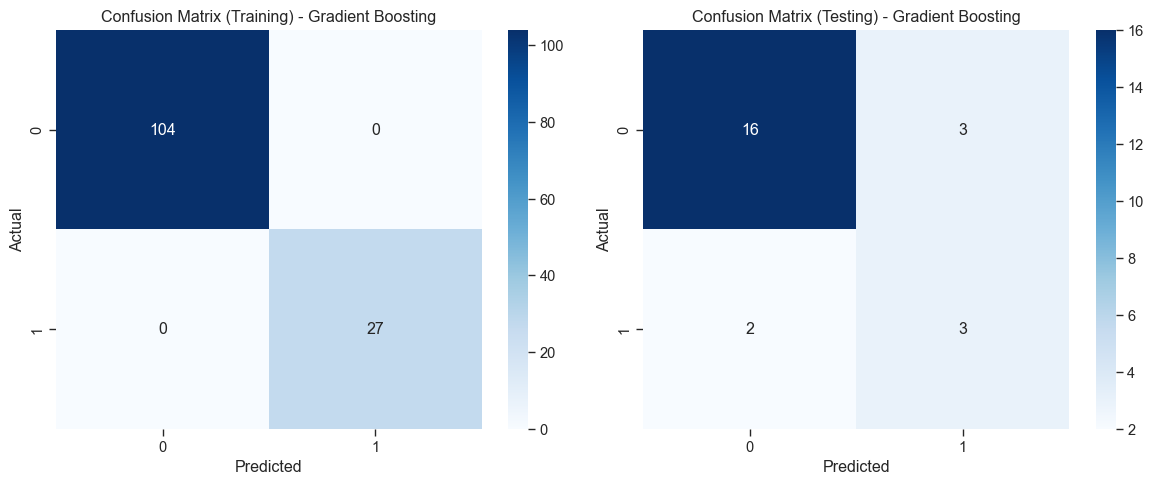

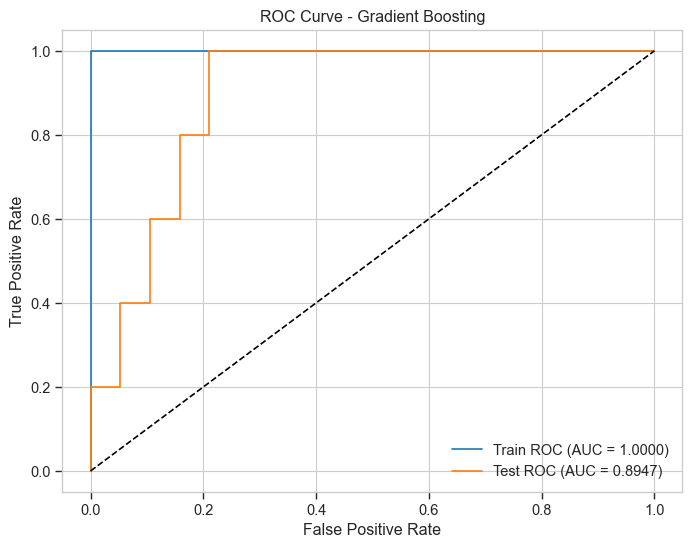

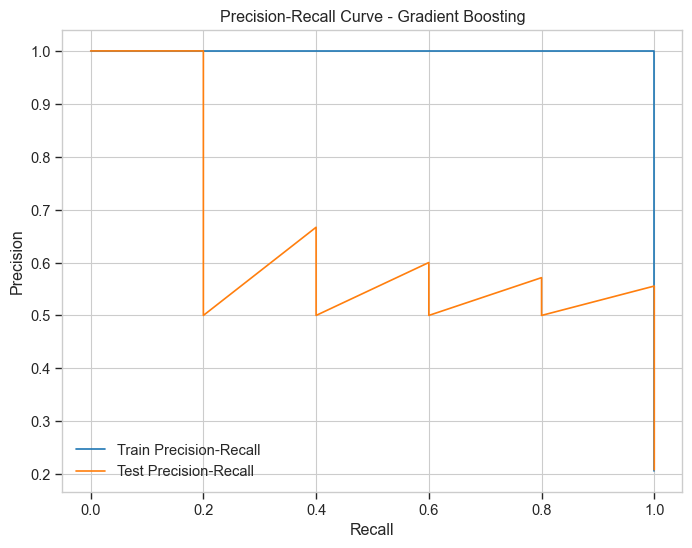

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
 

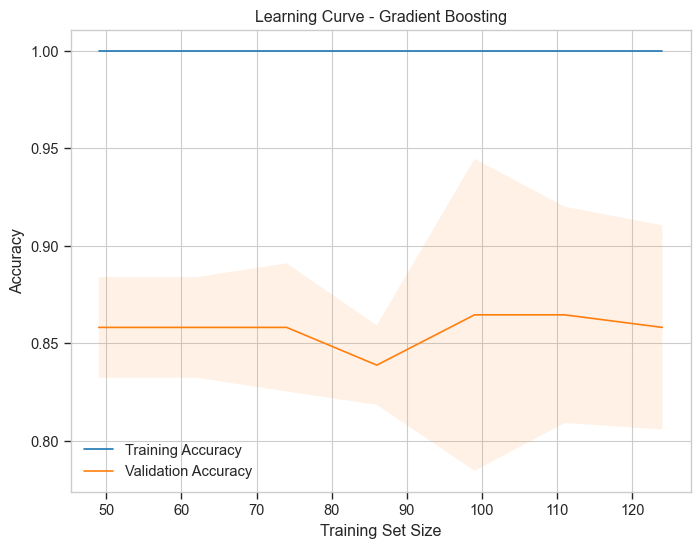


Feature Importance (Gradient Boosting):
Protime: 0.6535
Bilirubin: 0.1198
Ascites_1.0: 0.0685
Alk Phosphate: 0.0385
Ascites_2.0: 0.0353
Sex_2: 0.0258
Albumin: 0.0181
Sex_1: 0.0177
Varices_1.0: 0.0064
Varices_2.0: 0.0059
Fatigue_1.0: 0.0032
Sgot: 0.0025
Fatigue_2.0: 0.0017
Age: 0.0009
Histology_2: 0.0007
Spiders_2.0: 0.0005
Spiders_1.0: 0.0003
Malaise_1.0: 0.0003
Antivirals_1: 0.0002
Malaise_2.0: 0.0002
Spleen Palpable_1.0: 0.0001
Spleen Palpable_2.0: 0.0000
Histology_1: 0.0000
Antivirals_2: 0.0000
Liver Firm_1.0: 0.0000
Anorexia_1.0: 0.0000
Liver Firm_2.0: 0.0000
Steroid_1.0: 0.0000
Steroid_2.0: 0.0000
Liver Big_2.0: 0.0000
Liver Big_1.0: 0.0000
Anorexia_2.0: 0.0000


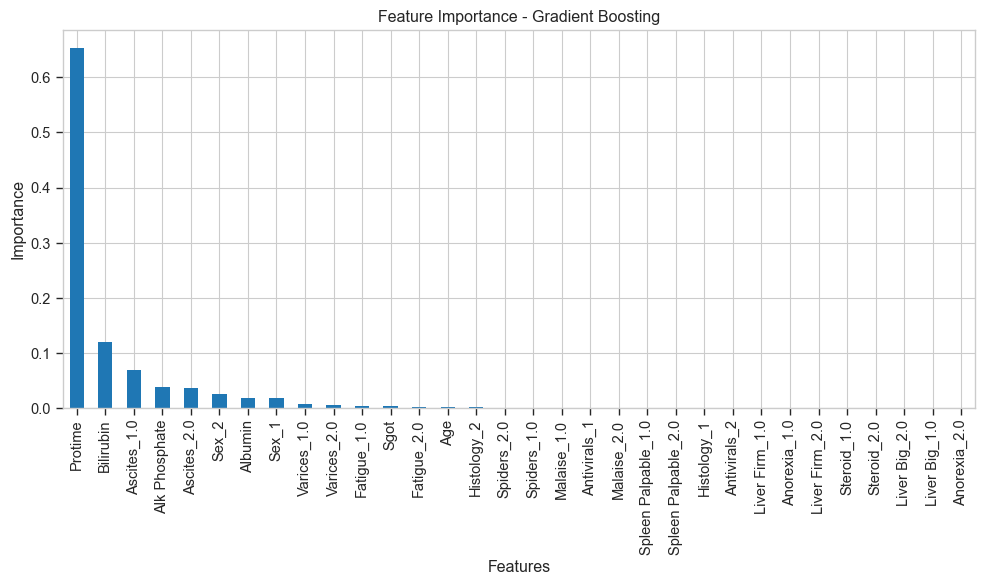

In [29]:
# --- Gradient Boosting Baseline ---
gb_model = GradientBoostingClassifier(random_state=42)
evaluate_model(gb_model, X_train, X_test, y_train, y_test, 'Gradient Boosting')

## AdaBoost


=== AdaBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1044 detik
Waktu Prediksi (Training Set): 0.0122 detik
Waktu Prediksi (Testing Set): 0.0108 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.9167
Precision: 0.8000
Recall: 0.8000
F1-Score: 0.8000

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.80      0.80      0.80         5

    accuracy                           0.92        24
   macro avg       0.87     

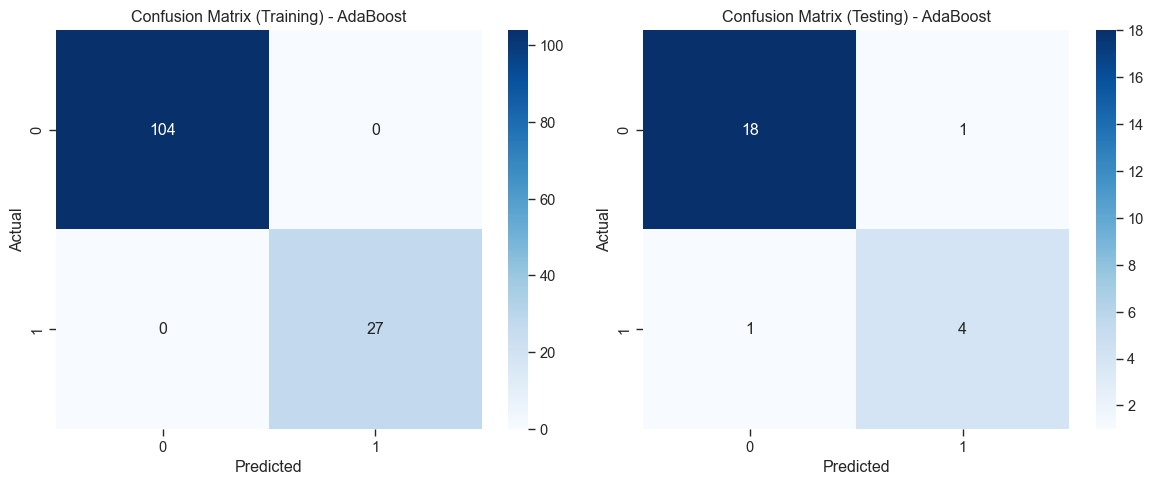

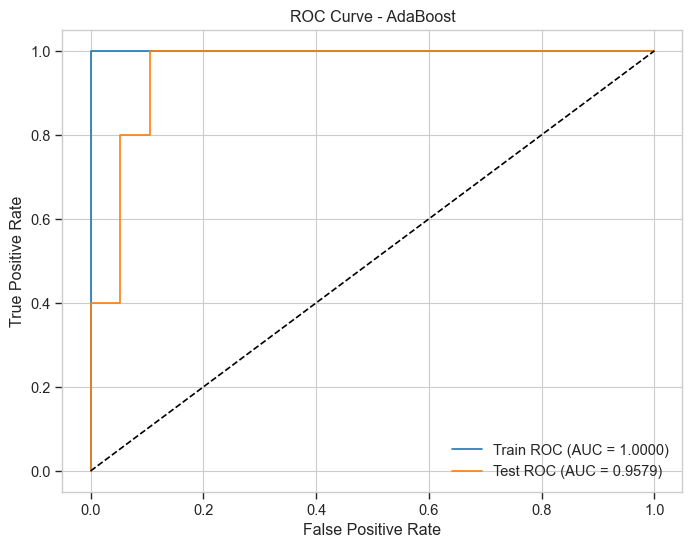

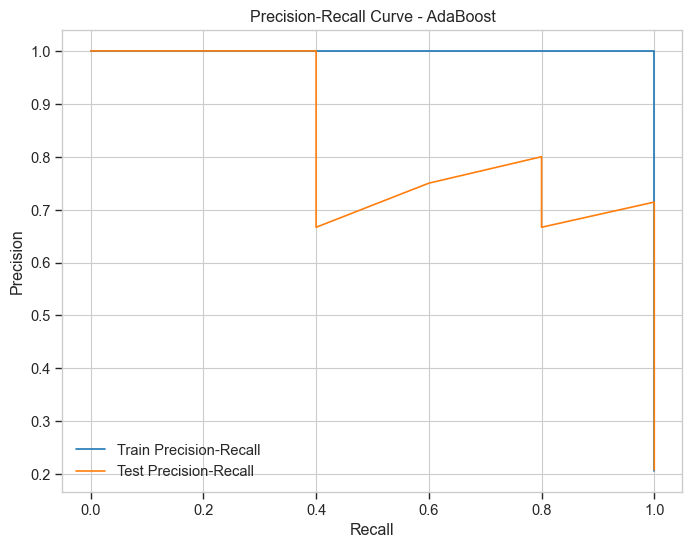

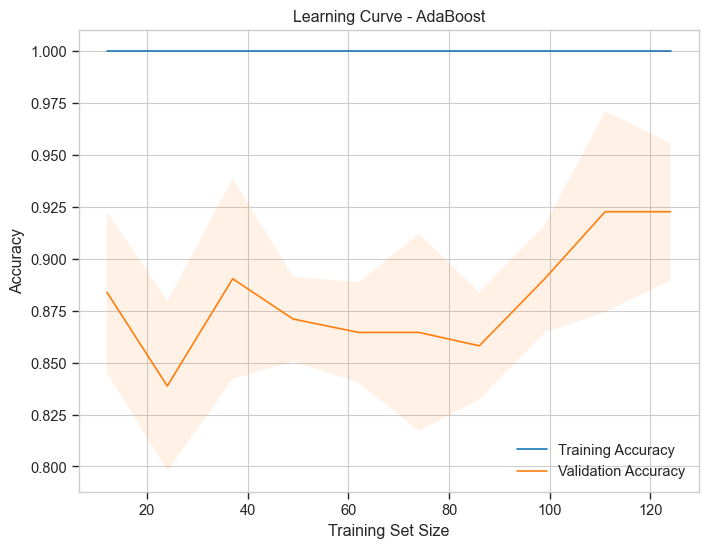


Feature Importance (AdaBoost):
Protime: 0.3473
Bilirubin: 0.2023
Age: 0.1240
Albumin: 0.1072
Alk Phosphate: 0.0481
Sgot: 0.0295
Ascites_1.0: 0.0288
Liver Big_2.0: 0.0236
Varices_2.0: 0.0231
Histology_2: 0.0230
Liver Firm_1.0: 0.0226
Sex_1: 0.0204
Antivirals_1: 0.0000
Spleen Palpable_1.0: 0.0000
Histology_1: 0.0000
Varices_1.0: 0.0000
Ascites_2.0: 0.0000
Sex_2: 0.0000
Spiders_2.0: 0.0000
Spiders_1.0: 0.0000
Spleen Palpable_2.0: 0.0000
Liver Firm_2.0: 0.0000
Antivirals_2: 0.0000
Steroid_1.0: 0.0000
Liver Big_1.0: 0.0000
Anorexia_2.0: 0.0000
Steroid_2.0: 0.0000
Malaise_2.0: 0.0000
Malaise_1.0: 0.0000
Fatigue_2.0: 0.0000
Fatigue_1.0: 0.0000
Anorexia_1.0: 0.0000


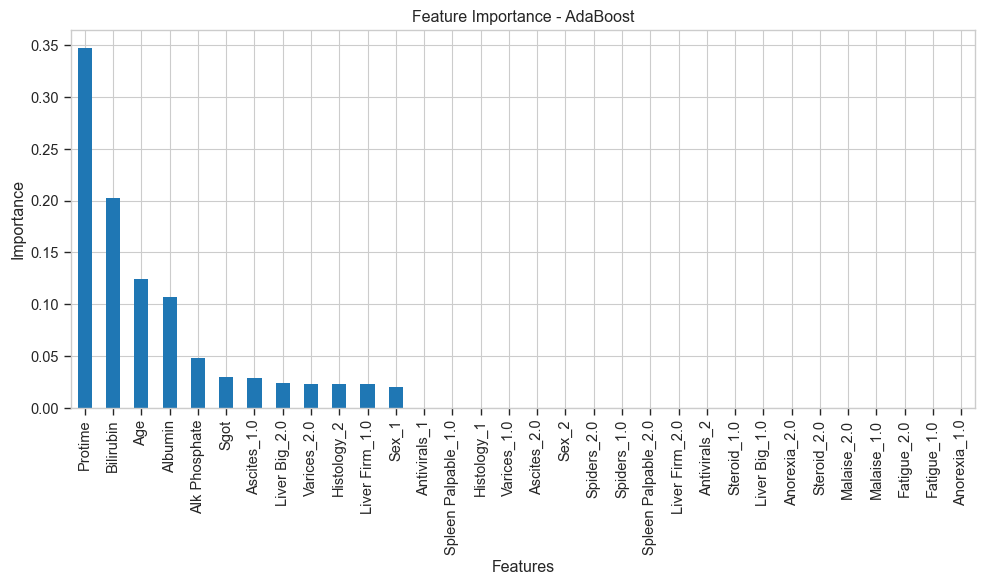

In [30]:
# --- AdaBoost Baseline ---
ada_model = AdaBoostClassifier(random_state=42)
evaluate_model(ada_model, X_train, X_test, y_train, y_test, 'AdaBoost')

## Extra Trees


=== Extra Trees Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.1156 detik
Waktu Prediksi (Training Set): 0.0095 detik
Waktu Prediksi (Testing Set): 0.0092 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.7917
Precision: 0.5000
Recall: 0.8000
F1-Score: 0.6154

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.50      0.80      0.62         5

    accuracy                           0.79        24
   macro avg       0.72  

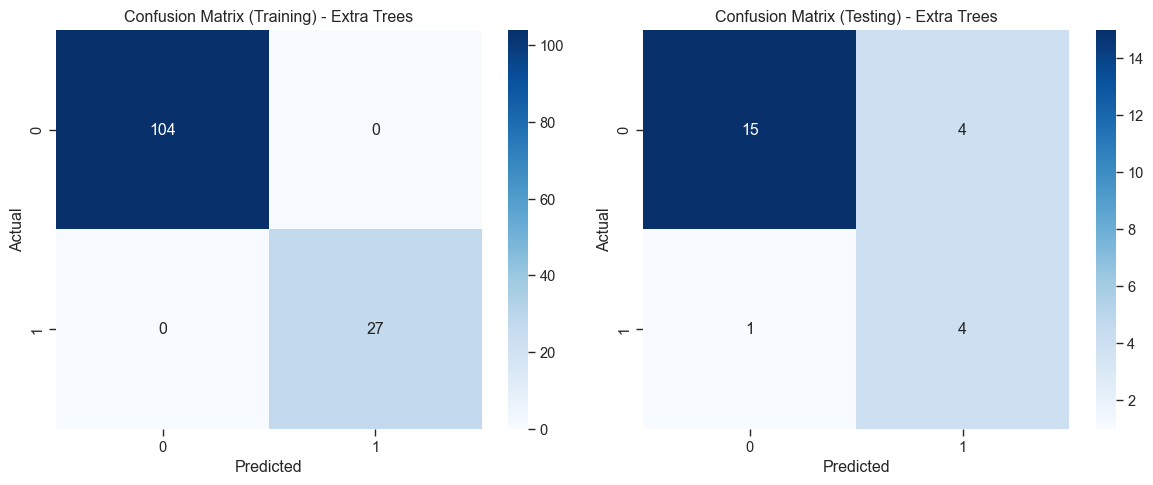

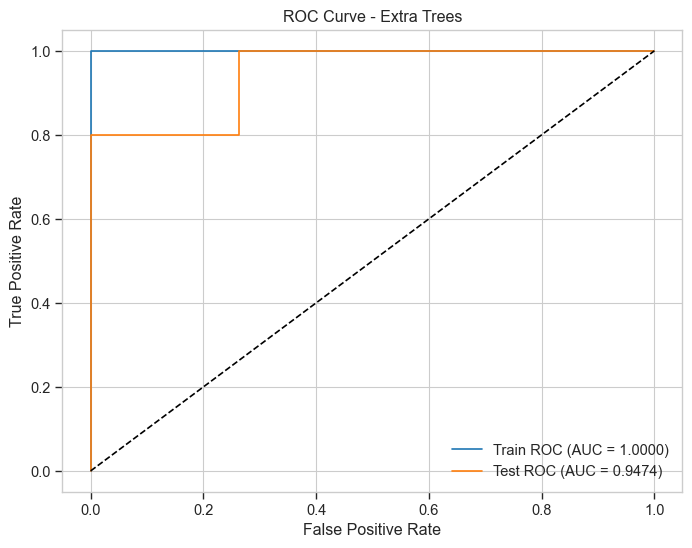

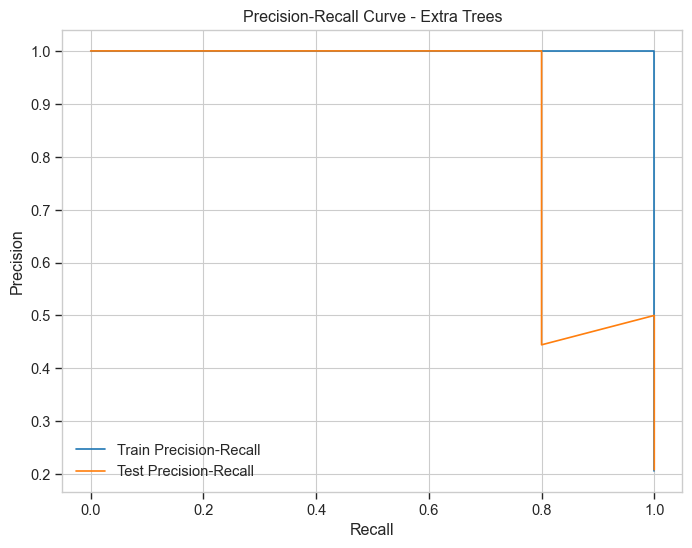

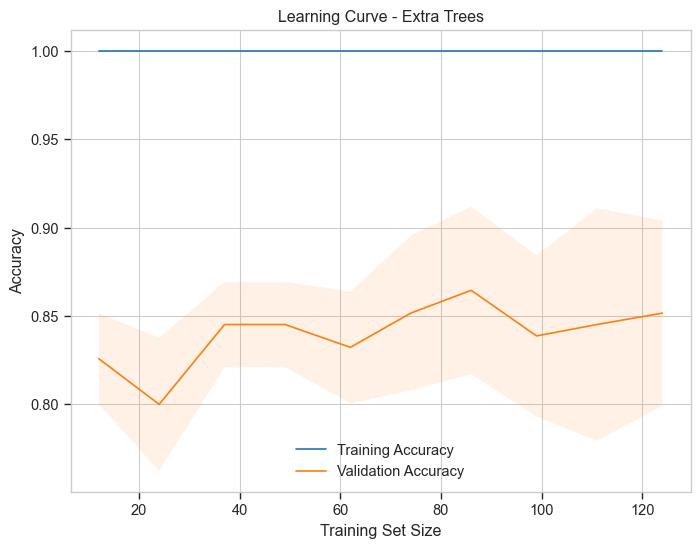


Feature Importance (Extra Trees):
Protime: 0.1435
Ascites_1.0: 0.0742
Ascites_2.0: 0.0684
Bilirubin: 0.0644
Albumin: 0.0580
Spiders_1.0: 0.0493
Spiders_2.0: 0.0486
Alk Phosphate: 0.0477
Liver Firm_2.0: 0.0379
Age: 0.0348
Liver Firm_1.0: 0.0346
Sgot: 0.0346
Varices_1.0: 0.0292
Histology_1: 0.0236
Histology_2: 0.0235
Malaise_2.0: 0.0234
Steroid_2.0: 0.0184
Steroid_1.0: 0.0174
Spleen Palpable_2.0: 0.0159
Varices_2.0: 0.0158
Malaise_1.0: 0.0153
Fatigue_1.0: 0.0140
Sex_2: 0.0136
Anorexia_2.0: 0.0133
Spleen Palpable_1.0: 0.0129
Sex_1: 0.0124
Fatigue_2.0: 0.0119
Anorexia_1.0: 0.0104
Liver Big_1.0: 0.0094
Antivirals_1: 0.0091
Liver Big_2.0: 0.0077
Antivirals_2: 0.0066


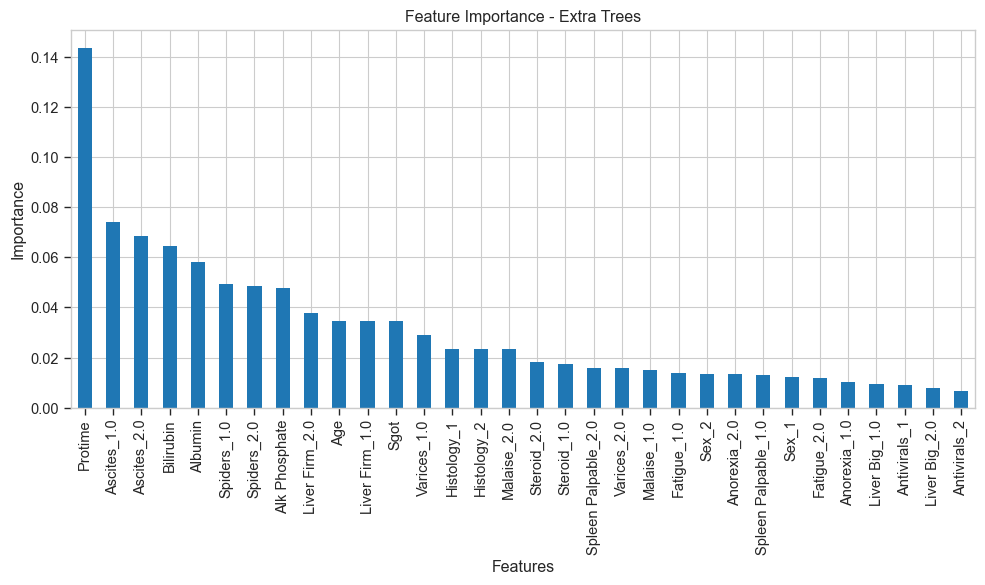

In [31]:
# --- Extra Trees Baseline ---
et_model = ExtraTreesClassifier(random_state=42)
evaluate_model(et_model, X_train, X_test, y_train, y_test, 'Extra Trees')

## XGBoost

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== XGBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.0960 detik
Waktu Prediksi (Training Set): 0.0085 detik
Waktu Prediksi (Testing Set): 0.0073 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.9167
Precision: 0.8000
Recall: 0.8000
F1-Score: 0.8000

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        19
           1       0.80      0.80      0.80         5

    accuracy                           0.92        24
   macro avg       0.87      

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Cross-Validation (5-Fold) Accuracy:
Scores: [0.9355 0.9355 0.871  0.9677 0.871 ]
Mean Accuracy: 0.9161 ± 0.0387


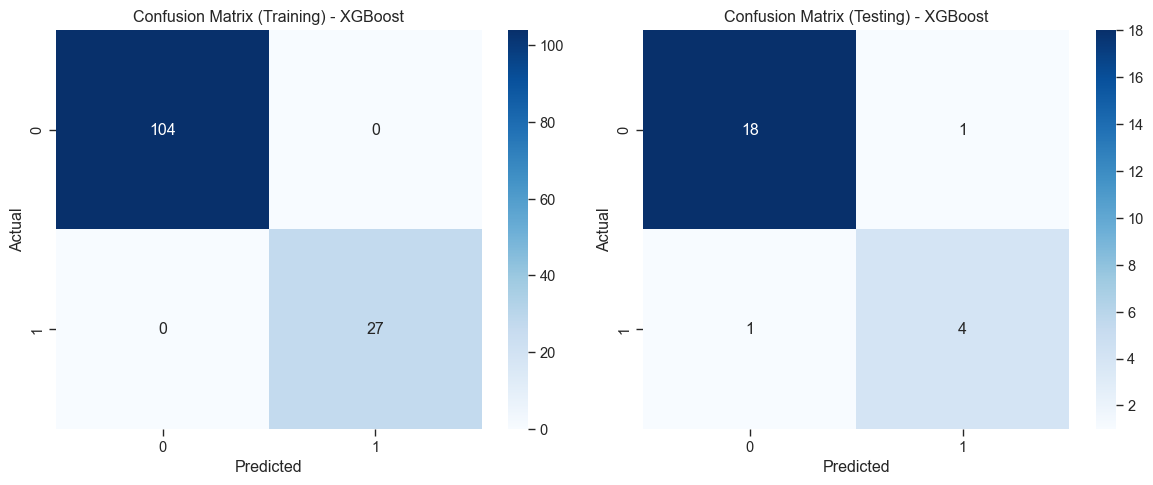

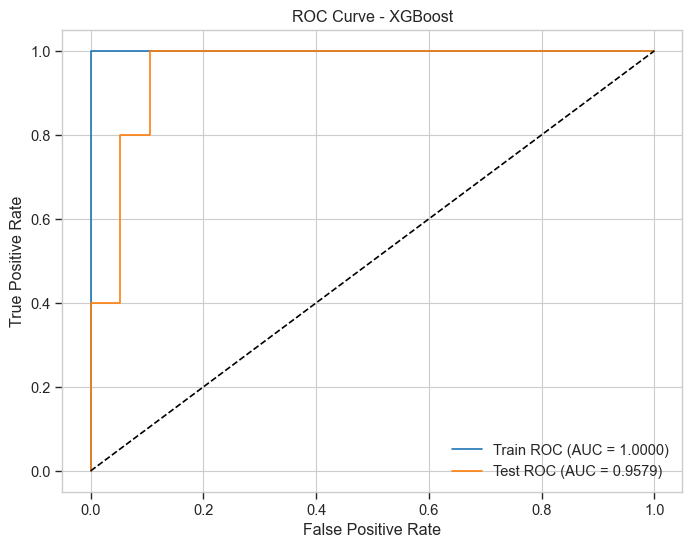

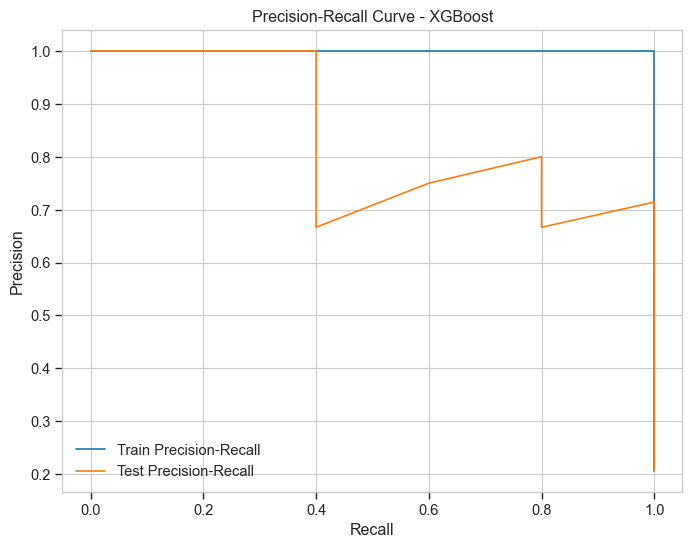

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: U

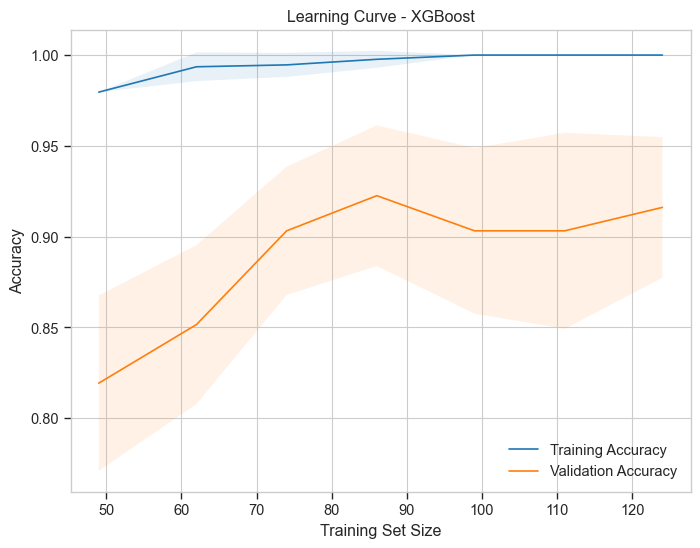


Feature Importance (XGBoost):
Protime: 0.3473
Ascites_1.0: 0.1551
Spiders_1.0: 0.0966
Albumin: 0.0881
Alk Phosphate: 0.0608
Bilirubin: 0.0603
Malaise_1.0: 0.0573
Age: 0.0530
Fatigue_1.0: 0.0325
Sgot: 0.0167
Histology_1: 0.0127
Steroid_1.0: 0.0103
Liver Firm_1.0: 0.0092
Spleen Palpable_1.0: 0.0000
Spleen Palpable_2.0: 0.0000
Ascites_2.0: 0.0000
Spiders_2.0: 0.0000
Varices_1.0: 0.0000
Varices_2.0: 0.0000
Liver Firm_2.0: 0.0000
Anorexia_1.0: 0.0000
Liver Big_2.0: 0.0000
Liver Big_1.0: 0.0000
Anorexia_2.0: 0.0000
Malaise_2.0: 0.0000
Fatigue_2.0: 0.0000
Antivirals_2: 0.0000
Antivirals_1: 0.0000
Steroid_2.0: 0.0000
Sex_2: 0.0000
Sex_1: 0.0000
Histology_2: 0.0000


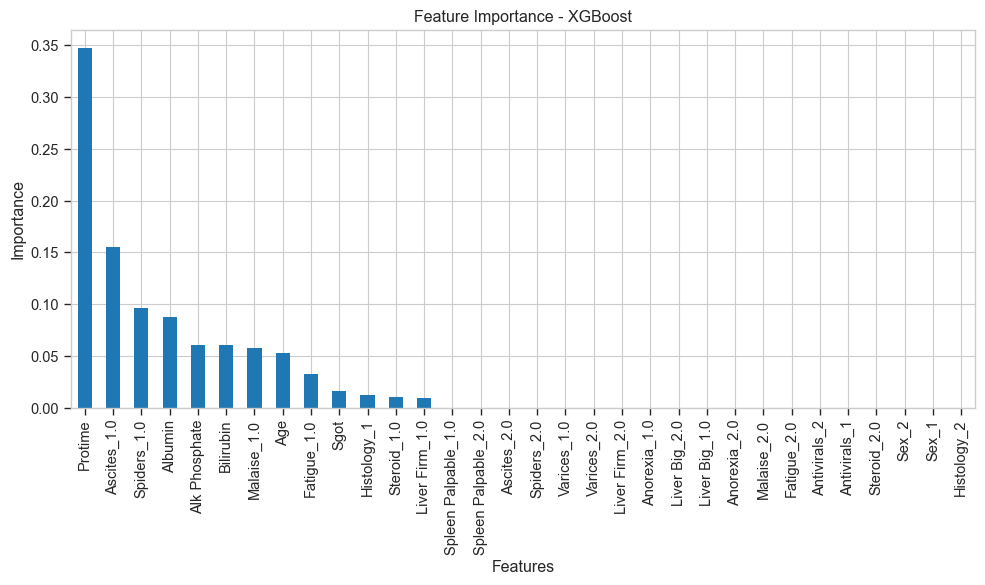

In [32]:
# --- XGBoost Baseline ---
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_model, X_train, X_test, y_train, y_test, 'XGBoost')

## LigthGBM

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 27, number of negative: 104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 187
[LightGBM] [Info] Number of data points in the train set: 131, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206107 -> initscore=-1.348554
[LightGBM] [Info] Start training from score -1.348554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

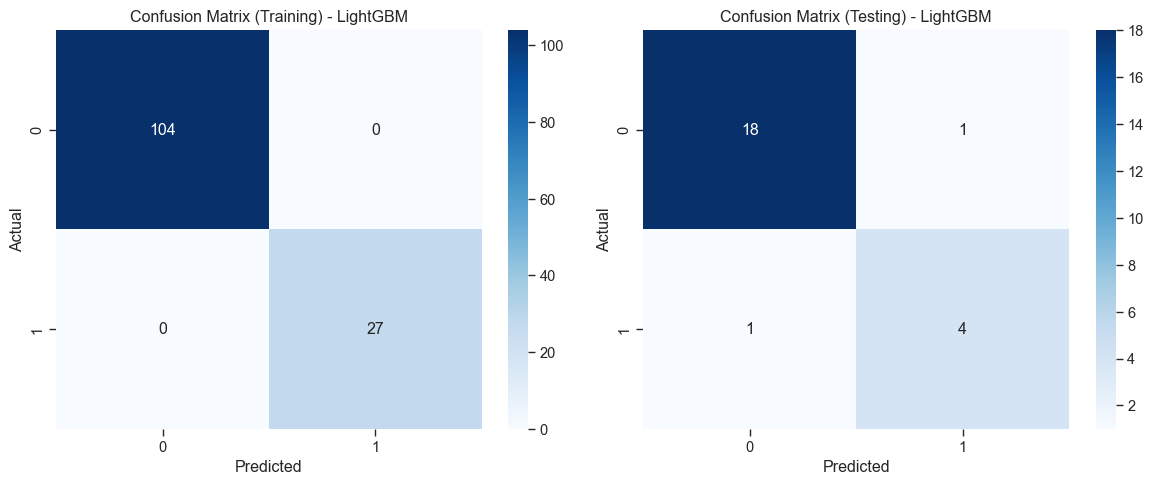

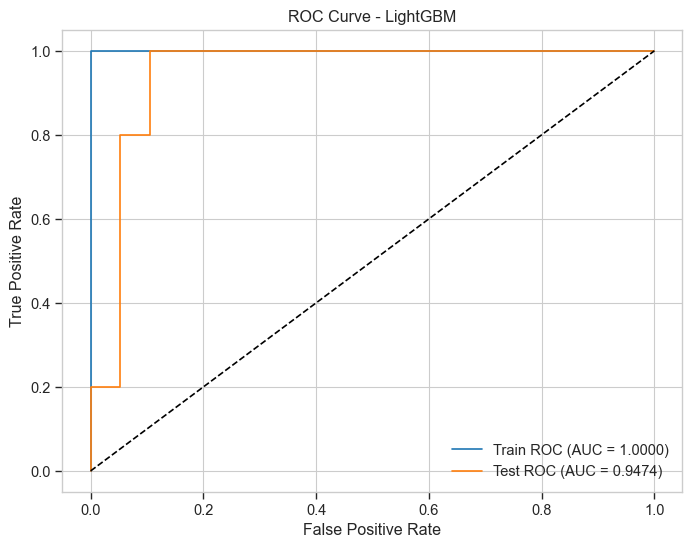

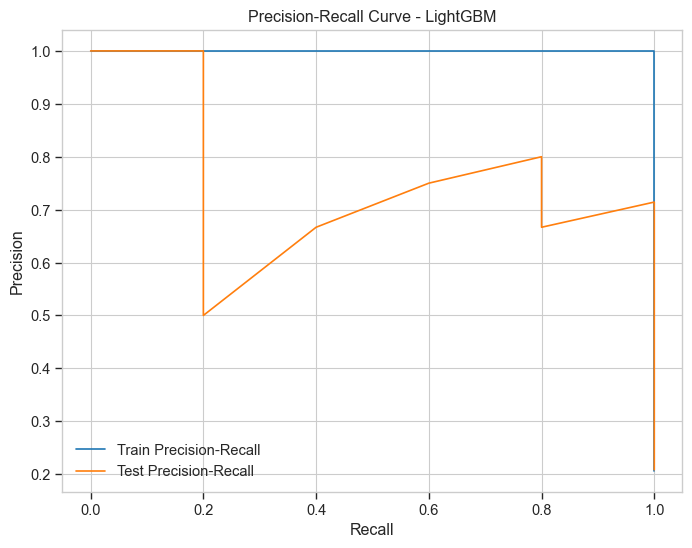

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Contains only one class
[LightGBM] [Info] Number of positive: 0, number of negative: 12
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 12, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000000 -> initscore=-34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stop

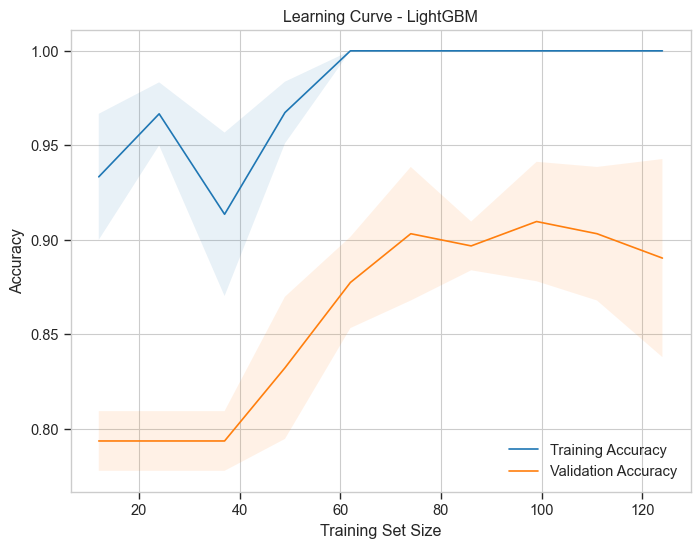


Feature Importance (LightGBM):
Protime: 108.0000
Age: 78.0000
Bilirubin: 74.0000
Alk Phosphate: 63.0000
Sgot: 42.0000
Albumin: 38.0000
Histology_1: 22.0000
Spiders_1.0: 21.0000
Liver Firm_1.0: 16.0000
Spiders_2.0: 12.0000
Fatigue_1.0: 9.0000
Liver Firm_2.0: 7.0000
Malaise_1.0: 7.0000
Steroid_1.0: 6.0000
Anorexia_2.0: 2.0000
Histology_2: 2.0000
Malaise_2.0: 1.0000
Steroid_2.0: 1.0000
Fatigue_2.0: 0.0000
Liver Big_1.0: 0.0000
Liver Big_2.0: 0.0000
Antivirals_2: 0.0000
Antivirals_1: 0.0000
Spleen Palpable_1.0: 0.0000
Spleen Palpable_2.0: 0.0000
Sex_2: 0.0000
Ascites_1.0: 0.0000
Ascites_2.0: 0.0000
Varices_1.0: 0.0000
Varices_2.0: 0.0000
Sex_1: 0.0000
Anorexia_1.0: 0.0000


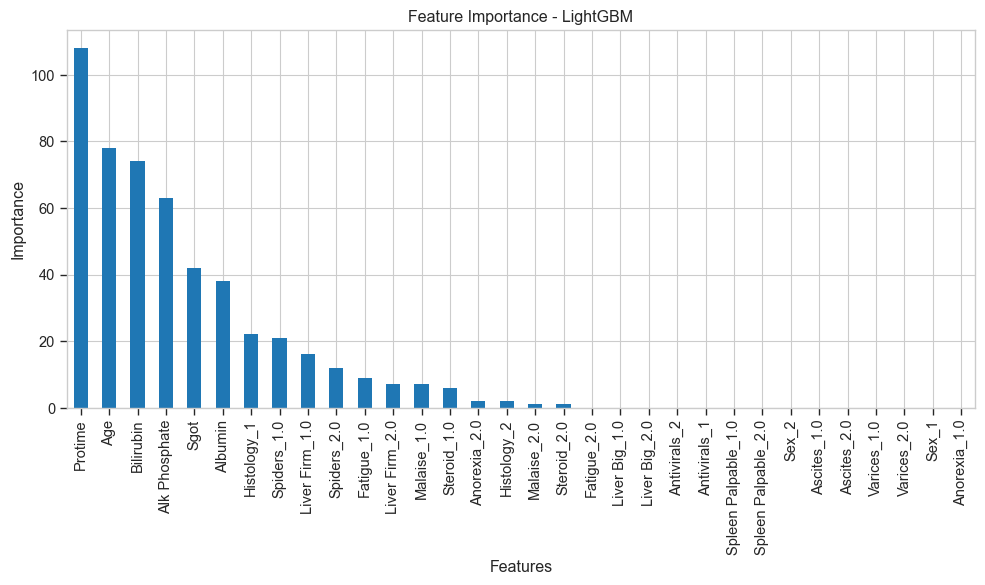

In [33]:
# --- LightGBM Baseline ---
lgb_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgb_model, X_train, X_test, y_train, y_test, 'LightGBM')

## CatBoost


=== CatBoost Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 3.0394 detik
Waktu Prediksi (Training Set): 0.0037 detik
Waktu Prediksi (Testing Set): 0.0028 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.9167
Precision: 0.7143
Recall: 1.0000
F1-Score: 0.8333

Classification Report (Testing):
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.71      1.00      0.83         5

    accuracy                           0.92        24
   macro avg       0.86     

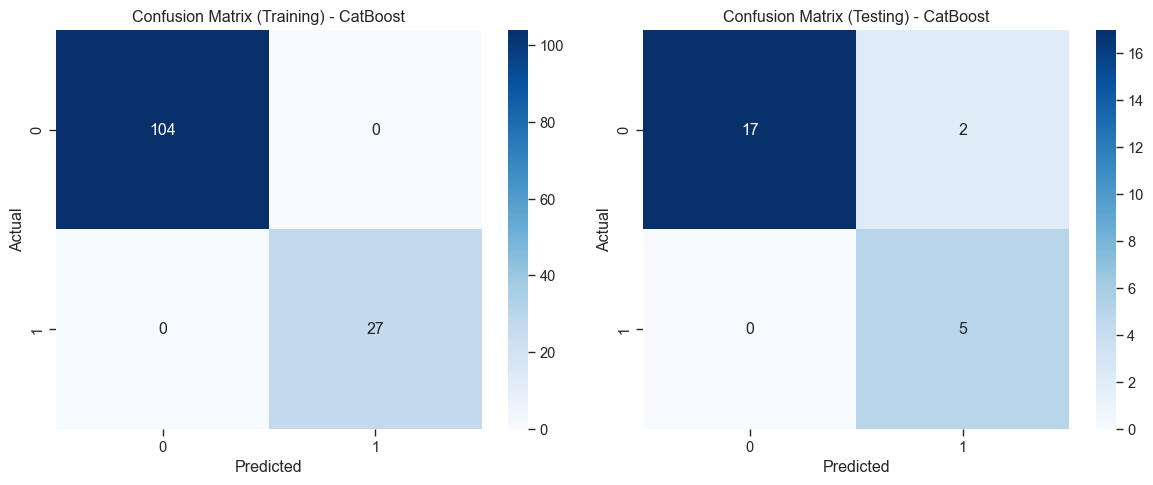

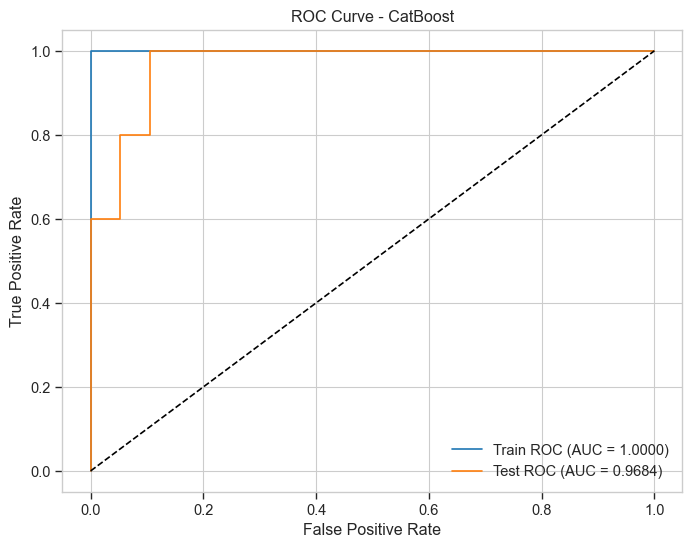

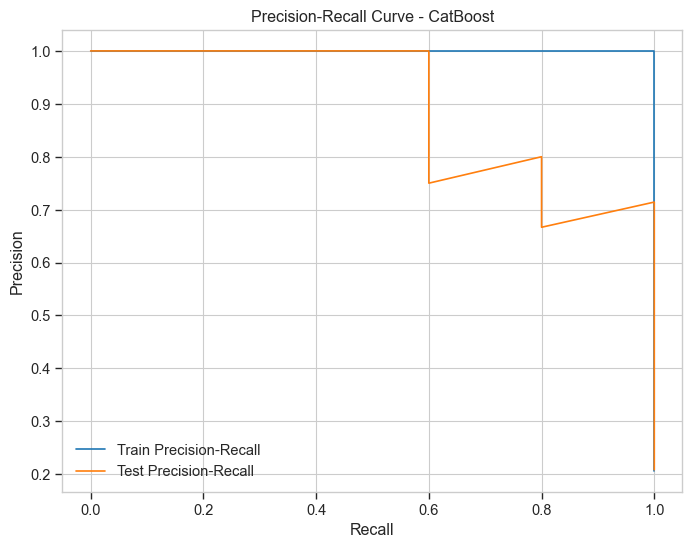

c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
3 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Michael Angello\AppData\Local\Programs\Python\Python311\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, N

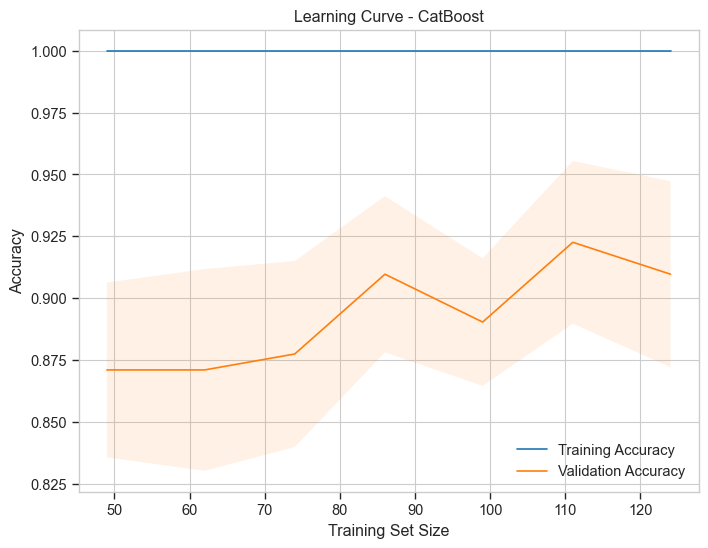


Feature Importance (CatBoost):
Protime: 41.7629
Alk Phosphate: 9.5780
Bilirubin: 8.4332
Albumin: 4.6605
Age: 4.2440
Sgot: 3.6633
Histology_2: 2.5037
Histology_1: 2.4392
Ascites_2.0: 2.2068
Spiders_2.0: 2.0913
Ascites_1.0: 1.9965
Spiders_1.0: 1.9605
Fatigue_2.0: 1.8619
Fatigue_1.0: 1.8146
Malaise_2.0: 1.1585
Steroid_1.0: 1.1436
Varices_2.0: 1.0063
Liver Firm_1.0: 0.9882
Varices_1.0: 0.9659
Malaise_1.0: 0.8130
Liver Firm_2.0: 0.7372
Sex_1: 0.6800
Sex_2: 0.6674
Steroid_2.0: 0.5900
Liver Big_2.0: 0.3371
Anorexia_2.0: 0.3312
Anorexia_1.0: 0.2733
Liver Big_1.0: 0.2670
Spleen Palpable_2.0: 0.2640
Spleen Palpable_1.0: 0.2412
Antivirals_1: 0.1734
Antivirals_2: 0.1462


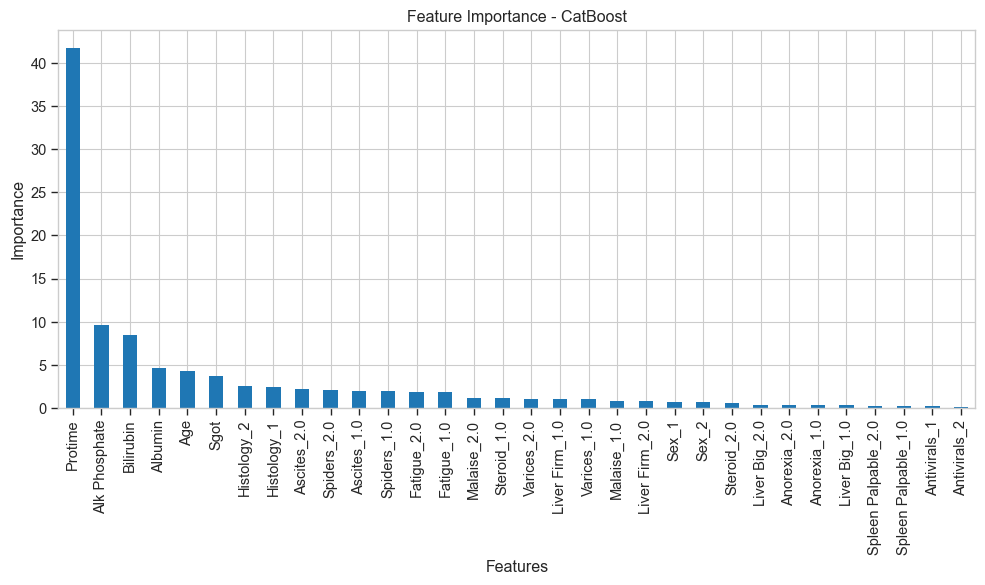

In [34]:
# --- CatBoost Baseline ---
cb_model = cb.CatBoostClassifier(random_state=42, verbose=0)
evaluate_model(cb_model, X_train, X_test, y_train, y_test, 'CatBoost')

## MLP


=== Neural Network (MLP) Baseline Model Evaluation ===

Waktu Komputasi:
Waktu Pelatihan: 0.3299 detik
Waktu Prediksi (Training Set): 0.0006 detik
Waktu Prediksi (Testing Set): 0.0003 detik

Training Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000

Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       104
           1       1.00      1.00      1.00        27

    accuracy                           1.00       131
   macro avg       1.00      1.00      1.00       131
weighted avg       1.00      1.00      1.00       131


Testing Performance:
Accuracy: 0.8750
Precision: 0.6667
Recall: 0.8000
F1-Score: 0.7273

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.94      0.89      0.92        19
           1       0.67      0.80      0.73         5

    accuracy                           0.88        24
   macro avg    

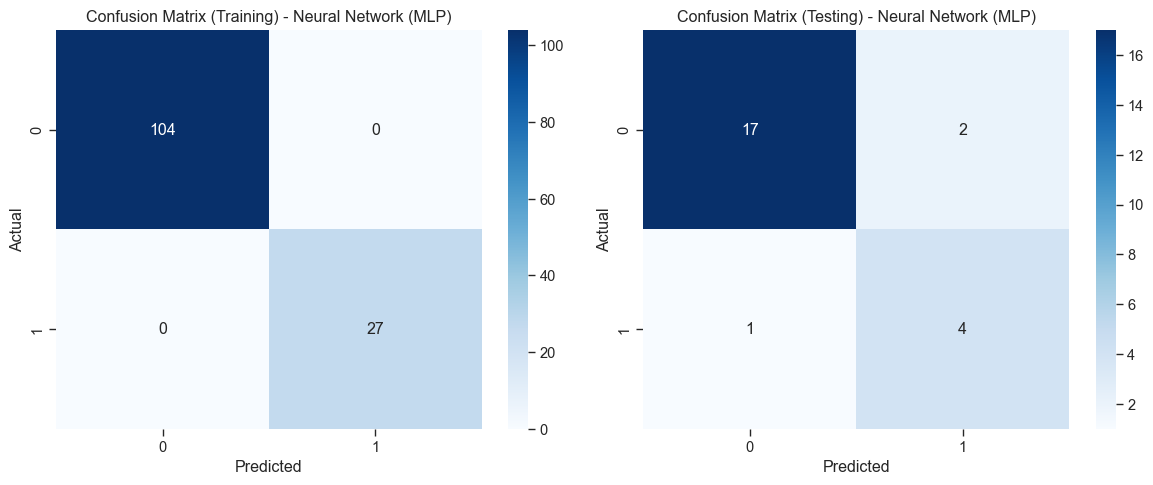

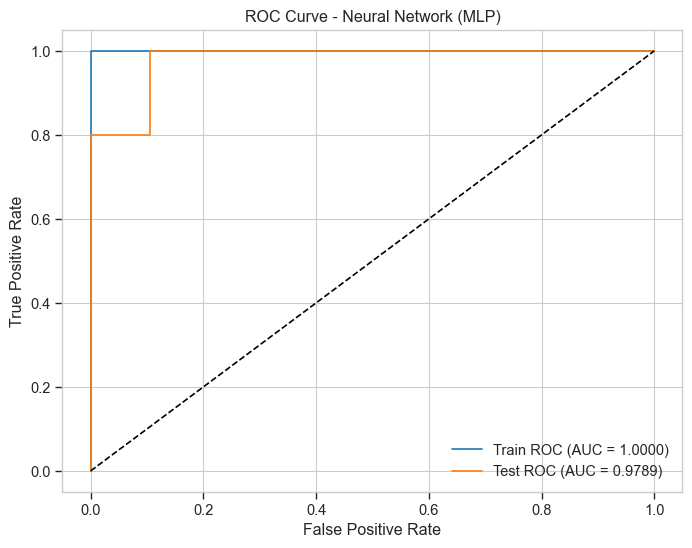

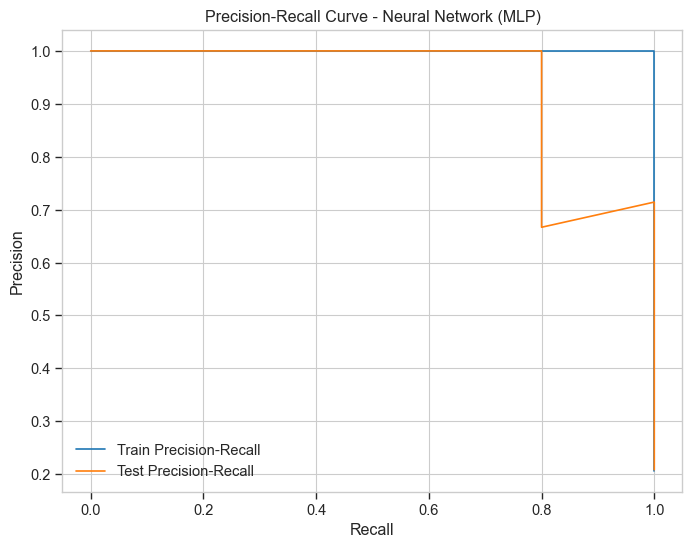

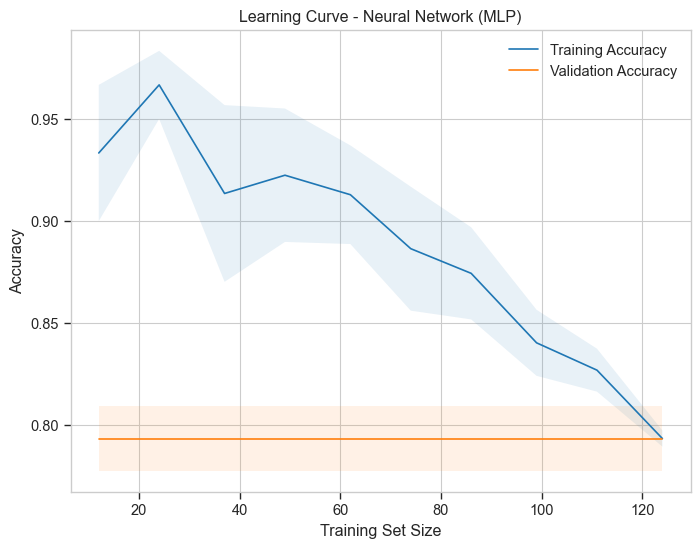

In [35]:
# --- Scale Data for Neural Network ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Neural Network (MLP) Baseline ---
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
evaluate_model(mlp_model, X_train_scaled, X_test_scaled, y_train, y_test, 'Neural Network (MLP)')